In [383]:
import os

from bs4 import BeautifulSoup
import requests
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.reset_orig()
# from collections import defaultdict

In [2]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['font.size'] = 12

## Scraping info from one listing

In [3]:
ex_page = "https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html"

In [194]:
ex_page = "https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html"

In [4]:
r = requests.get(ex_page)

In [5]:
soup = BeautifulSoup(r.text, "lxml")

In [6]:
panel_bodies = soup.find_all("div", "panel-body")

In [200]:
with open("debug.html", "w") as f:
    f.write(str(soup))

In [7]:
panel_info = panel_bodies[0]

In [182]:
price_translation = {
    'miete': "base_rent",
    "nebenkosten": "utilities",
    "sonstige_kosten": "miscellaneous_costs",
    "kaution": "deposit",
    "abstandszahlung": "existing_equipment_fees"
}

def get_price_dict(panel):
    raw_prices = panel.find('div', 'col-xs-12 col-sm-5')
    price_list = [x.text.lower().strip().strip(":€").replace(" ", "_")
                  for x in raw_prices.find_all('td') 
                  if not x.text.upper().strip().startswith('SCHUFA')]
    price_dict = {}
    for name, price in zip(price_list[:-1:2], price_list[1::2]):
        price_dict[name] = price
    for k, v in price_translation.items():
        if k in price_dict.keys():
            price_dict[v] = price_dict[k]
            price_dict.pop(k, None)
    return price_dict

In [173]:
get_price_dict(panel_info)

{'base_rent': '410',
 'deposit': '1300',
 'miscellaneous_costs': '25',
 'utilities': '80'}

In [54]:
def get_address_dict(panel):
    raw_address = panel.find('div', 'col-xs-12 col-sm-4').find('a').text
    address_parts = [x.strip() for x in  raw_address.split('\n') if x.strip() != '']
    house_line =  re.sub(r'  +', ' ', address_parts[0])
    house_parts = house_line.split()
    house_number = -1
    for hp in house_parts:
        if hp.isdigit():
            house_number = hp
            house_line = house_line.replace(house_number, "").strip()
            break
    street = house_line

    postcode_line = re.sub(r'  +', ' ', address_parts[1])
    postcode_line = re.sub(r'Germany', '', postcode_line, flags=re.I | re.UNICODE)
    postcode_line = re.sub(r'Hamburg', '', postcode_line, flags=re.I | re.UNICODE)
    postcode_line = re.sub(r'[\n ]+', ' ', postcode_line)
    postcode_pattern = re.compile(r'(?P<postcode>2[\d]+) (?P<region>.*)', flags=re.I | re.UNICODE)
    postcode_match = postcode_pattern.search(postcode_line)
    postcode = postcode_match['postcode']
    region = postcode_match['region']    
    return {'street': street, 'house_number': int(house_number), 'region': postcode_match['region'], 'postcode': int(postcode_match['postcode'])}

In [55]:
get_address_dict(panel_info)

{'house_number': -1,
 'postcode': 20259,
 'region': 'Eimsbüttel',
 'street': 'Osterstraße'}

In [56]:
def get_availability_dict(panel):
    availability = panel.find('div', 'col-xs-12 col-sm-3')
    availability_values = [x.text.strip() for x in availability.find_all('b')]
    return dict(zip(['start_date', 'ad_placed'], availability_values))

In [57]:
get_availability_dict(panel_info)

{'ad_placed': 'Online: 5 Stunden', 'start_date': '23.04.2017'}

In [58]:
panel_details = panel_bodies[1]

In [201]:
def get_details_dict(panel):
    raw_details, searching_details = panel.find_all('div', 'col-sm-6')
    space_pattern = re.compile(r'[\n ]+')
    details_parts = [space_pattern.sub(' ', x.text.strip()) for x in raw_details.find_all('li')]
    details_text = " ".join(details_parts)
    
    room_area = 0
    area_pattern = re.compile(r'[0-9]+')
    area_match = area_pattern.match(details_parts[0].split()[0])
    if area_match:
        room_area = int(area_match[0])

    total_area = 0
    size_pattern = re.compile(r'Wohnungsgröße: ([0-9]+)', flags=re.I)
    size_match = size_pattern.search(details_parts[1])
    if size_match:
        total_area = int(size_match[1])

    total_num_persons = 0
    np_pattern = re.compile(r'([0-9]+)er WG')
    num_persons_match = np_pattern.search(details_text)
    if num_persons_match:
        total_num_persons = int(num_persons_match[1])

    num_females, num_males = 0, 0
    male_female_pattern = re.compile(r'([0-9]+) Frau(?:en)? und ([0-9]+) Männer',  flags=re.I)
    genders_match = male_female_pattern.search(details_text)
    if genders_match:
        num_females, num_males = int(genders_match[1]), int(genders_match[2])

    workers_pattern = re.compile(r'Berufstätigen-WG', flags=re.I | re.U)
    students_pattern = re.compile(r'Studenten-WG', flags=re.I)
    workers_ok, students_ok = False, False
    workers_ok = not workers_pattern.search(details_text)
    students_ok = not students_pattern.search(details_text)
    
    languages = []
    for lang_img in raw_details.find_all('img'):
        languages.append(lang_img['title'].lower())
    
    current_min_age, current_max_age = -1, -1
    current_age_pattern = re.compile(r"Bewohneralter: (\d+) bis (\d+) Jahre", flags=re.I | re.U)
    current_age_match = current_age_pattern.search(details_text)
    if current_age_match:
        current_min_age, current_max_age = int(current_age_match[1]), int(current_age_match[2])
    
    desired_min_age, desired_max_age = -1, -1
    desired_age_pattern = re.compile(r"zwischen (\d+) und (\d+) Jahren", flags=re.I | re.U)
    desired_age_match = desired_age_pattern.search("".join(searching_details.text))
    if desired_age_match:
        desired_min_age, desired_max_age = int(desired_age_match[1]), int(desired_age_match[2])
    
    return {'room_area': room_area, 'total_area': total_area, 
            'num_males_current': num_males, 'num_females_current': num_females, 
            'total_occupancy': total_num_persons,
            'workers_ok': workers_ok, 'students_ok': students_ok,
            "languages": languages,
            "current_min_age": current_min_age, "current_max_age": current_max_age,
            "desired_min_age": desired_min_age, "desired_max_age": desired_max_age}

In [202]:
get_details_dict(panel_details)

{'current_max_age': 26,
 'current_min_age': 24,
 'desired_max_age': 30,
 'desired_min_age': 18,
 'languages': ['deutsch', 'englisch'],
 'num_females_current': 0,
 'num_males_current': 2,
 'room_area': 12,
 'students_ok': False,
 'total_area': 0,
 'total_occupancy': 3,
 'workers_ok': False}

In [337]:
panel_features = panel_bodies[2]

In [352]:
f = re.sub(r' {2,}', '', panel_features.text)
[x.replace('\n', ' ') for x in re.split(r'\n{2,}', f) if x]

['Angaben zum Objekt',
 'Altbau',
 'Dusche',
 'Flatrate',
 'DSL, Flatrate, WLAN26-50 Mbit/s',
 'Dielen',
 'schlechte Parkmöglichkeiten',
 '1 Minute zu Fuß entfernt',
 'Waschmaschine, Spülmaschine, Balkon, Keller']

In [382]:
def get_features_dict(panel):
    features_dict = {}
    f = re.sub(r' {2,}', '', panel.text)
    flist = [x.replace('\n', ' ').lower() for x in re.split(r'\n{2,}', f) if x]

    # Now pick out certain features
    def _find_keyword(keyword):
        return any(keyword.lower() in x for x in flist)
    
    if _find_keyword('altbau'):
        features_dict['building'] = "old"
    if _find_keyword('neubau'): 
        features_dict['building'] = "new"
    
    features_dict['balcony'] = _find_keyword('balkon')
    features_dict['washing_machine'] = _find_keyword('waschmaschine')
    features_dict['dishwasher'] = _find_keyword('spülmaschine')
    features_dict['cellar'] = _find_keyword('keller')
    
    features_dict['transport_distance'] = -1
    for x in flist:
        match = re.search(r'([0-9]+) minute(n)? zu fuß', x, flags=re.I | re.U)
        if match:
            features_dict['transport_distance'] = int(match[1])
            break
    
    return features_dict

get_features_dict(panel_features)

{'balcony': True,
 'building': 'old',
 'cellar': True,
 'dishwasher': True,
 'transport_distance': 1,
 'washing_machine': True}

In [392]:
def check_ad_useful(soup):
    return "der Inserent hat bereits genug Anfragen erhalten" not in soup.text or "Anzeige nicht vorhanden" not in soup.text

In [393]:
def extract_ad_info_from_soup(ad_soup):
    panels = ad_soup.find_all("div", "panel-body")
    try:
        info_panel = panels[0]

        ad_dict = dict()
#         ad_dict = {'title': ad_soup.title.text}
        ad_dict.update(get_price_dict(info_panel))
        ad_dict.update(get_address_dict(info_panel))

        details_panel = panels[1]
        ad_dict.update(get_details_dict(details_panel))
        
        features_panel = panels[2]
        ad_dict.update(get_features_dict(features_panel))
    except IndexError:
        print("Cannot parse page")
        with open("debug.html", "w") as f:
            f.write(ad_soup.get_text())
        return None
    
    return ad_dict

In [374]:
extract_ad_info_from_soup(soup)

{'balcony': True,
 'base_rent': '410',
 'building': 'old',
 'cellar': True,
 'current_max_age': 26,
 'current_min_age': 24,
 'deposit': '1300',
 'desired_max_age': 30,
 'desired_min_age': 18,
 'dishwasher': True,
 'house_number': -1,
 'languages': ['deutsch', 'englisch'],
 'miscellaneous_costs': '25',
 'num_females_current': 0,
 'num_males_current': 2,
 'postcode': 20259,
 'region': 'Eimsbüttel',
 'room_area': 12,
 'street': 'Osterstraße',
 'students_ok': False,
 'total_area': 0,
 'total_occupancy': 3,
 'utilities': '80',
 'washing_machine': True,
 'workers_ok': False}

In [465]:
def generate_cache_filename(url):
    return os.path.join("_cache", os.path.basename(url))    

In [466]:
def extract_ad_info(url, read_cache=True, save_cache=True):
    cache_filename = generate_cache_filename(url)
    cache_dir = os.path.dirname(cache_filename)
    
    page_contents = None
    
    if read_cache and os.path.isfile(cache_filename):
        print("Reading from cache", cache_filename)
        with open(cache_filename) as f:
            page_contents = f.read()
    else:    
        r = requests.get(url)
        if r.status_code != 200 or not r.ok:
            return None
        page_contents = r.text
        
    if save_cache and not os.path.isfile(cache_filename):
        print("Cacheing to", cache_filename)
        if not os.path.isdir(cache_dir):
            os.makedirs(cache_dir)
        with open(cache_filename, "w") as fout:
            fout.write(r.text)
            
    soup = BeautifulSoup(page_contents, 'lxml')
    if not check_ad_useful(soup):
        return None
    else:
        ad_dict = extract_ad_info_from_soup(soup)
        ad_dict['url'] = url
        return ad_dict

In [467]:
# failure
extract_ad_info('https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-St-Pauli.5796749.html')

Reading from cache _cache/wg-zimmer-in-Hamburg-St-Pauli.5796749.html


{'balcony': False,
 'base_rent': 'n.a.',
 'building': 'old',
 'cellar': True,
 'current_max_age': -1,
 'current_min_age': -1,
 'desired_max_age': -1,
 'desired_min_age': -1,
 'dishwasher': False,
 'house_number': -1,
 'languages': ['deutsch', 'englisch', 'polnisch', 'russisch'],
 'miscellaneous_costs': 'n.a.',
 'num_females_current': 0,
 'num_males_current': 0,
 'postcode': 20357,
 'region': 'St Pauli',
 'room_area': 0,
 'street': 'Sternstrasse',
 'students_ok': True,
 'total_area': 60,
 'total_occupancy': 3,
 'transport_distance': 2,
 'url': 'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-St-Pauli.5796749.html',
 'utilities': 'n.a.',
 'washing_machine': True,
 'workers_ok': False}

In [468]:
extract_ad_info('http://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html')

Reading from cache _cache/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html


{'balcony': False,
 'base_rent': '450',
 'building': 'old',
 'cellar': True,
 'current_max_age': 28,
 'current_min_age': 26,
 'deposit': '500',
 'desired_max_age': 30,
 'desired_min_age': 23,
 'dishwasher': True,
 'house_number': 21,
 'languages': ['deutsch', 'englisch', 'spanisch', 'französisch'],
 'miscellaneous_costs': 'n.a.',
 'num_females_current': 0,
 'num_males_current': 2,
 'postcode': 20144,
 'region': 'Eimsbüttel',
 'room_area': 16,
 'street': 'Kielortallee',
 'students_ok': True,
 'total_area': 78,
 'total_occupancy': 3,
 'transport_distance': 5,
 'url': 'http://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html',
 'utilities': '50',
 'washing_machine': True,
 'workers_ok': False}

In [163]:
extract_ad_info('http://www.wg-gesucht.de/6091141.html')

{'base_rent': '370',
 'current_max_age': 37,
 'current_min_age': 26,
 'deposit': '370',
 'desired_max_age': 60,
 'desired_min_age': 18,
 'house_number': -1,
 'languages': ['Deutsch', 'Dänisch', 'Englisch'],
 'miscellaneous_costs': '0',
 'num_females_current': 1,
 'num_males_current': 2,
 'postcode': 22607,
 'region': 'Bahrenfeld',
 'room_area': 15,
 'street': 'Bökenkamp',
 'students_ok': True,
 'title': '15qm Zimmer in entspannter WG - Möbliertes Zimmer  Hamburg-Bahrenfeld',
 'total_area': 90,
 'total_occupancy': 4,
 'utilities': '0',
 'workers_ok': True}

In [72]:
get_listing_dict(listings[0])

{'date_advertised': '25.04.17',
 'distance': '9,7 km',
 'room_area': '12m²',
 'start_date': '01.05.17',
 'total_rent': '400€',
 'url': 'wg-zimmer-in-Hamburg-Alsterdorf.5260672.html'}

In [168]:
import time
import random

In [169]:
def scrape_urls(url_list):
    print('Getting info on %d ads...' % len(url_list))
    dict_list = []
    for url in url_list:
        print(url)
        time.sleep(random.random()*5 + 1)
        info = extract_ad_info(url)
        if info:
            dict_list.append(info)
    return dict_list

In [412]:
urls = [
    'http://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.5313515.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eppendorf.6066386.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.5986295.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6082464.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Nord.5672745.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Stellingen.6079042.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6074471.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Harvestehude.5963393.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Nord.6064793.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.4979594.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.5248077.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6059676.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Altstadt.6048834.html'
]

In [413]:
dicts = scrape_urls(urls)

Getting info on 16 ads...
http://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.5313515.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Bahrenfeld.5313515.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eppendorf.6066386.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eppendorf.6066386.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.5986295.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Ottensen.5986295.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6082464.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eimsbuettel.6082464.html
https://www.wg-gesuch

## Scraping to get lots of listings

In [446]:
list_page = "https://www.wg-gesucht.de/wg-zimmer-in-Hamburg.55.0.0.0.html?user_filter_id=397074&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dFr=1493589600&dTo=1497391200&radLat=53.55602559999999&radLng=9.922616500000004&radAdd=Ottensen%2C+Hamburg%2C+Germany&radDis=7000&wgSea=2&wgAge=26&wgMxT=3&img_only=1"

In [447]:
rall = requests.get(list_page)

In [448]:
soup_all = BeautifulSoup(rall.text, 'lxml')

In [449]:
listings = soup_all.find_all('tr', class_=re.compile(r'listenansicht[01]'))

In [450]:
len(listings)

20

In [451]:
def get_listing_dict(listing):
    listing_info = [s.text.strip() for s in listing.find_all('span') if s.text.strip()]
    listing_cols = ['date_advertised', 'total_rent', 'room_area', 'distance', 'start_date']
    listing_dict = dict(zip(listing_cols, listing_info))
    listing_dict['url'] = "https://www.wg-gesucht.de/" + listing.find('a', class_=re.compile('listenansicht[01]'), href=re.compile('wg-.*'))['href']
    listing_dict['room_area'] = int(re.match(r'[0-9]+', listing_dict['room_area'])[0])
    listing_dict['total_rent'] = int(listing_dict['total_rent'].strip('€'))
    listing_dict['distance'] = float(listing_dict['distance'].strip(" km").replace(",", "."))
    return listing_dict

In [452]:
get_listing_dict(listings[0])

{'date_advertised': '01.05.17',
 'distance': 0.6,
 'room_area': 30,
 'start_date': '01.06.17',
 'total_rent': 650,
 'url': 'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.6007384.html'}

In [453]:
get_listing_dict(listings[1])

{'date_advertised': '01.05.17',
 'distance': 1.1,
 'room_area': 17,
 'start_date': '01.06.17',
 'total_rent': 554,
 'url': 'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.6095695.html'}

In [454]:
def get_listings_from_list_page(url):
    rall = requests.get(url)
    soup_all = BeautifulSoup(rall.text, 'lxml')
    listings = soup_all.find_all('tr', class_=re.compile(r'listenansicht[01]'))
    listings_dicts = [get_listing_dict(listing) for listing in listings]
    print("Got %d listings" % len(listings_dicts))
    return listings_dicts
    

In [455]:
list_page_start = "https://www.wg-gesucht.de/wg-zimmer-in-Hamburg.55.0.0.0.html?user_filter_id=395235&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dTo=1494108000&radLat=53.57915999999999&radLng=9.874555800000053&radAdd=Altona%2C+Hamburg%2C+Germany&radDis=10000&wgSea=2&wgAge=26&wgMxT=2&img_only=1"
list_page_template = list_page_start.replace("0.html", "{N}.html")

In [534]:
listings_dicts = []
for i in range(6):
    list_page = list_page_template.replace("{N}", str(i))
    time.sleep(random.random()*5 + 1)    
    print("Getting listings from", list_page)
    listings_dicts.extend(get_listings_from_list_page(list_page))

Getting listings from https://www.wg-gesucht.de/wg-zimmer-in-Hamburg.55.0.0.0.html?user_filter_id=395235&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dTo=1494108000&radLat=53.57915999999999&radLng=9.874555800000053&radAdd=Altona%2C+Hamburg%2C+Germany&radDis=10000&wgSea=2&wgAge=26&wgMxT=2&img_only=1
Got 20 listings
Getting listings from https://www.wg-gesucht.de/wg-zimmer-in-Hamburg.55.0.0.1.html?user_filter_id=395235&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dTo=1494108000&radLat=53.57915999999999&radLng=9.874555800000053&radAdd=Altona%2C+Hamburg%2C+Germany&radDis=10000&wgSea=2&wgAge=26&wgMxT=2&img_only=1
Got 20 listings
Getting listings from https://www.wg-gesucht.de/wg-zimmer-in-Hamburg.55.0.0.2.html?user_filter_id=395235&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dTo=1494108000&radLat=53.57915999999999&radLng=9.874555800000053&radAdd=Altona%2C+Hamburg%2C+Germany&radDis=10000&wgSea=2&wgAge=26&wgMxT=2&img_only=1
Got 2

In [535]:
len(listings_dicts)

120

In [536]:
for i, d in enumerate(listings_dicts):
    if not os.path.isfile(generate_cache_filename(d['url'])):
        if i % 10 == 0 and i > 0:
            print('Long sleep, done %d / %d' % (i, len(listings_dicts)))
            time.sleep(60)
        time.sleep(random.random()*2 + 1)
    print(d['url'])
    info = extract_ad_info(d['url'])
    if info:
        d.update(info)

https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Alsterdorf.5260672.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Alsterdorf.5260672.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Sternschanze.5328615.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Sternschanze.5328615.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Nord.5852381.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Altona-Nord.5852381.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Altstadt.6068575.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Altona-Altstadt.6068575.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Nord.5934963.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Altona-Nord.5934963.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Hoheluft-Ost.3327760.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Hoheluft-Ost.3327760.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.6092676.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Bahrenfe

https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eidelstedt.5895819.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eidelstedt.5895819.html
Long sleep
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5136014.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eimsbuettel.5136014.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Neustadt.6062760.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Neustadt.6062760.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Altstadt.6048834.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Altona-Altstadt.6048834.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Nord.5876002.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Altona-Nord.5876002.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6059977.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eimsbuettel.6059977.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Altstadt.5643697.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Altona-Altstadt.5643697.html
https://www.wg-

https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-St-Pauli.5984102.html
Cacheing to _cache/wg-zimmer-in-Hamburg-St-Pauli.5984102.html


# Dataframes

In [537]:
df = pd.DataFrame(listings_dicts)

In [414]:
df = pd.DataFrame(dicts)

In [538]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 32 columns):
balcony                    120 non-null bool
base_rent                  120 non-null object
building                   80 non-null object
cellar                     120 non-null bool
current_max_age            120 non-null int64
current_min_age            120 non-null int64
date_advertised            120 non-null object
deposit                    108 non-null object
desired_max_age            120 non-null int64
desired_min_age            120 non-null int64
dishwasher                 120 non-null bool
distance                   120 non-null float64
existing_equipment_fees    38 non-null object
house_number               120 non-null int64
languages                  120 non-null object
miscellaneous_costs        120 non-null object
num_females_current        120 non-null int64
num_males_current          120 non-null int64
postcode                   120 non-null int64
region           

In [539]:
for col in ['base_rent', 'deposit', 'existing_equipment_fees', 'miscellaneous_costs', 'utilities']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(value=0)
df.drop(df.query('base_rent == 0').index, inplace=True)

In [540]:
for col in ['date_advertised', 'start_date']:
    df[col] = pd.to_datetime(df[col], dayfirst=True)

In [541]:
# turn language list into dummy variables
s = df['languages']
# need to do the .apply.stack as geT_dummies doens't behave properly
dummy_lang = pd.get_dummies(s.apply(pd.Series).stack(), prefix="speaks").sum(level=0)
df = pd.concat([df, dummy_lang], axis=1)  
# get NaNs for ads that have 0 languages
for c in dummy_lang.columns.values:
    df[c] = pd.to_numeric(df[c].fillna(value=0), downcast='integer')

In [542]:
df

,balcony,base_rent,building,cellar,current_max_age,current_min_age,date_advertised,deposit,desired_max_age,desired_min_age,...,workers_ok,speaks_deutsch,speaks_englisch,speaks_französisch,speaks_italienisch,speaks_japanisch,speaks_niederländisch,speaks_polnisch,speaks_portugiesisch,speaks_spanisch
0,True,370,NaN,False,24,20,2017-05-01,600.0,27,16,...,True,1,1,0,0,0,0,0,0,0
1,False,398,old,False,-1,-1,2017-05-01,479.0,-1,-1,...,False,1,1,1,0,0,0,0,0,0
2,False,380,NaN,True,39,39,2017-04-30,380.0,86,26,...,True,1,1,0,0,0,0,0,0,0
3,False,360,old,False,29,20,2017-04-30,1100.0,-1,-1,...,False,1,1,0,0,0,0,0,0,0
4,False,400,NaN,True,-1,-1,2017-04-30,900.0,38,20,...,False,1,1,0,0,0,0,0,0,0
5,False,481,old,False,-1,-1,2017-04-29,250.0,55,25,...,False,0,0,0,0,0,0,0,0,0
6,False,355,old,True,33,33,2017-04-29,700.0,35,23,...,False,1,1,1,0,0,0,0,0,0
7,True,303,old,False,30,18,2017-04-28,800.0,-1,-1,...,False,1,0,0,0,0,0,0,0,0
8,True,410,old,True,26,24,2017-04-28,1300.0,30,18,...,False,1,1,0,0,0,0,0,0,0
9,True,370,NaN,True,29,28,2017-04-28,400.0,-1,-1,...,False,1,0,0,0,0,0,0,0,0


In [543]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 41 columns):
balcony                    120 non-null bool
base_rent                  120 non-null int64
building                   80 non-null object
cellar                     120 non-null bool
current_max_age            120 non-null int64
current_min_age            120 non-null int64
date_advertised            120 non-null datetime64[ns]
deposit                    120 non-null float64
desired_max_age            120 non-null int64
desired_min_age            120 non-null int64
dishwasher                 120 non-null bool
distance                   120 non-null float64
existing_equipment_fees    120 non-null float64
house_number               120 non-null int64
languages                  120 non-null object
miscellaneous_costs        120 non-null float64
num_females_current        120 non-null int64
num_males_current          120 non-null int64
postcode                   120 non-null int64
region

In [544]:
df.region.unique().tolist()

['Alsterdorf',
 'Sternschanze',
 'Altona-Nord',
 'Altona-Altstadt',
 'Hoheluft-Ost',
 'Bahrenfeld',
 'Eppendorf',
 'Eimsbüttel',
 'Stellingen',
 'St. Georg',
 'Winterhude',
 'Barmbek-Süd',
 'St Georg',
 'Ottensen',
 'Rotherbaum',
 'Münzviertel Hammerbrook / St. Georg',
 'Lokstedt',
 'Neustadt',
 'Schanzenviertel',
 'Finkenwerder',
 'Osdorf',
 'Harvestehude',
 'Altona/ ottensen',
 'Halstenbek / Halstenbek',
 'Eidelstedt',
 'Othmarschen',
 'Uhlenhorst',
 'Lurup',
 'Iserbrook',
 'Niendorf',
 'Wilhelmsburg',
 'St Pauli',
 'Bezirk Eimsbüttel//Niendorf',
 'Altona',
 'Krupunder',
 'Hoheluft-West']

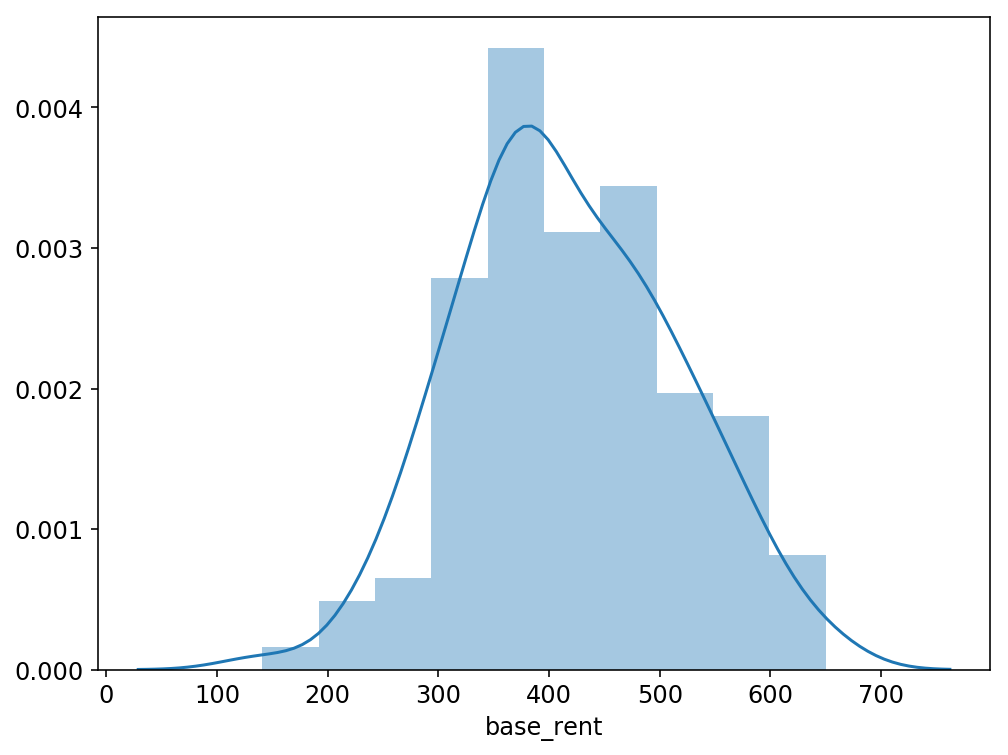

In [576]:
sns.distplot(df.base_rent);

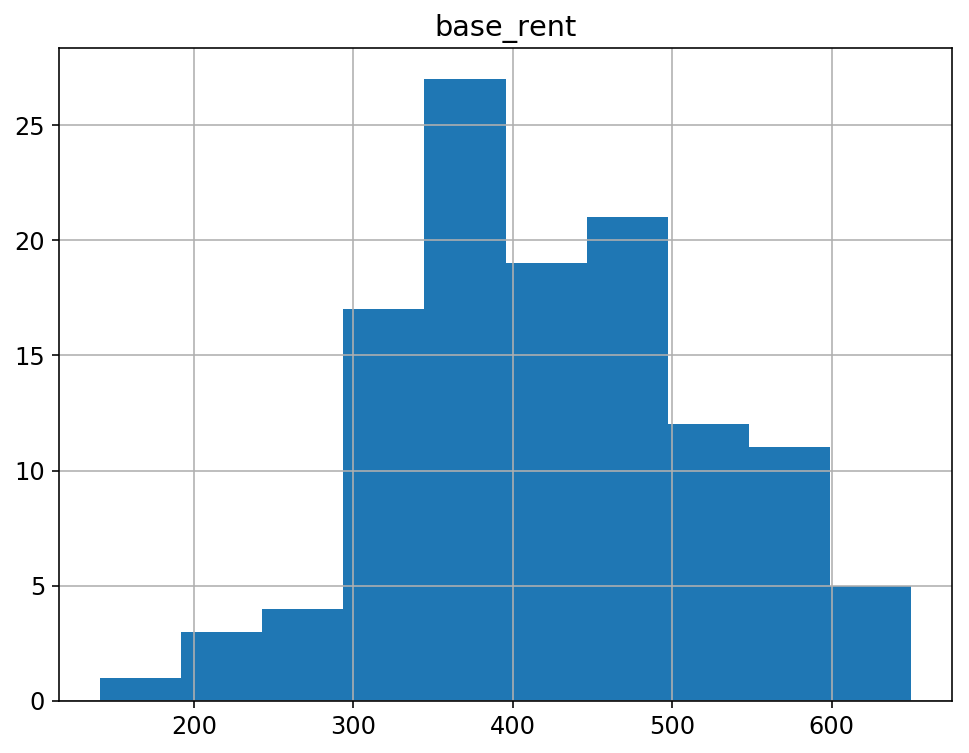

In [685]:
df.hist('base_rent');

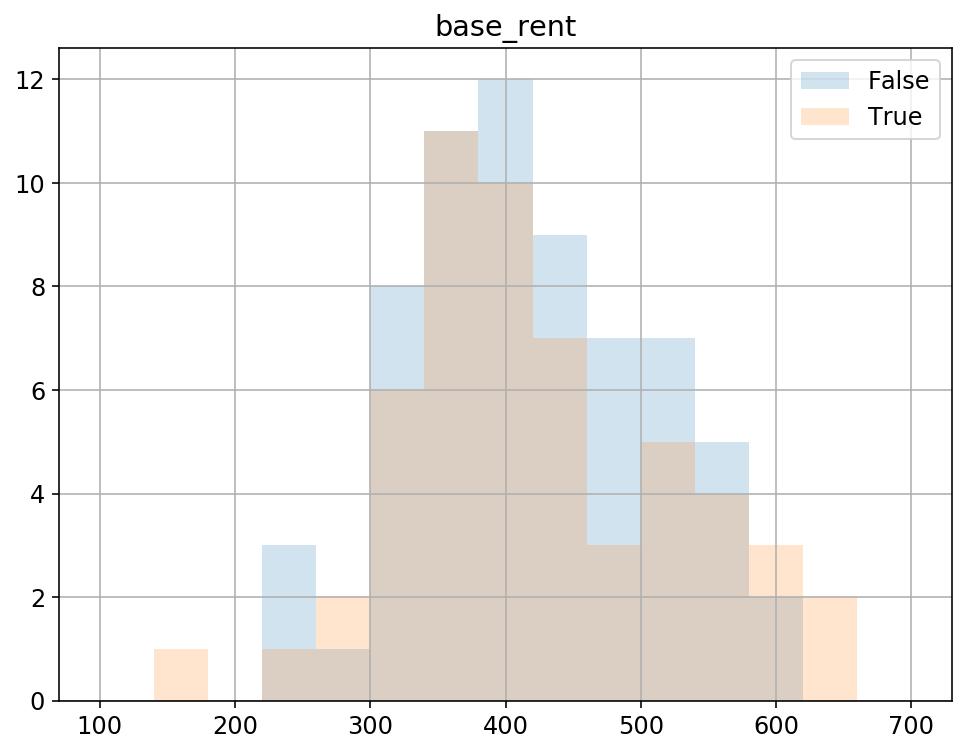

In [690]:
grps = df.groupby('balcony')
for key, grp in df.groupby('balcony'):
    grp.hist('base_rent', sharex=True, sharey=True, ax=plt.gca(),
             bins=15, range=[100, 700], histtype='stepfilled', alpha=0.2, 
             normed=False, label=str(key))
plt.legend();

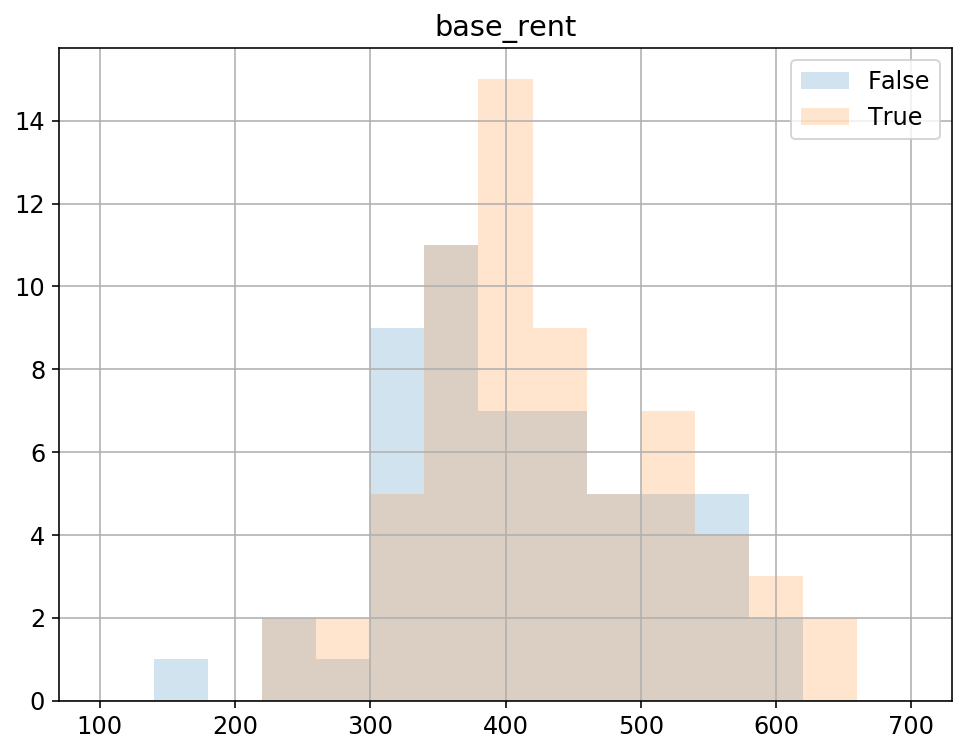

In [691]:
grps = df.groupby('cellar')
for key, grp in df.groupby('cellar'):
    grp.hist('base_rent', sharex=True, sharey=True, ax=plt.gca(),
             bins=15, range=[100, 700], histtype='stepfilled', alpha=0.2, 
             normed=False, label=str(key))
plt.legend();

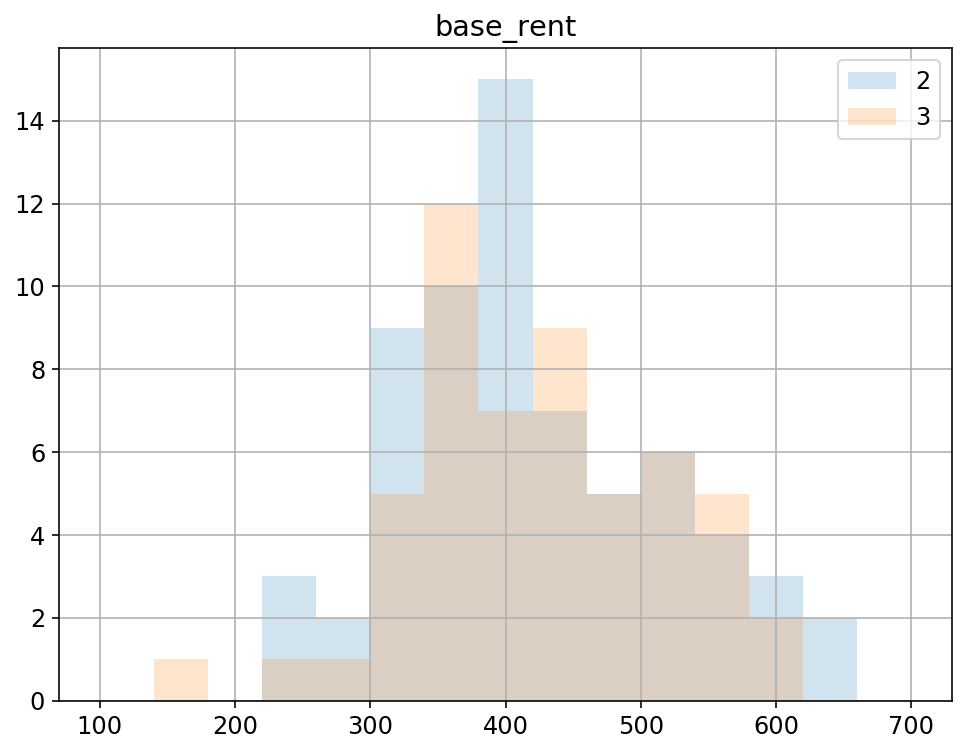

In [692]:
grps = df.groupby('total_occupancy')
for key, grp in df.groupby('total_occupancy'):
    grp.hist('base_rent', sharex=True, sharey=True, ax=plt.gca(),
             bins=15, range=[100, 700], histtype='stepfilled', alpha=0.2, 
             normed=False, label=str(key))
plt.legend();

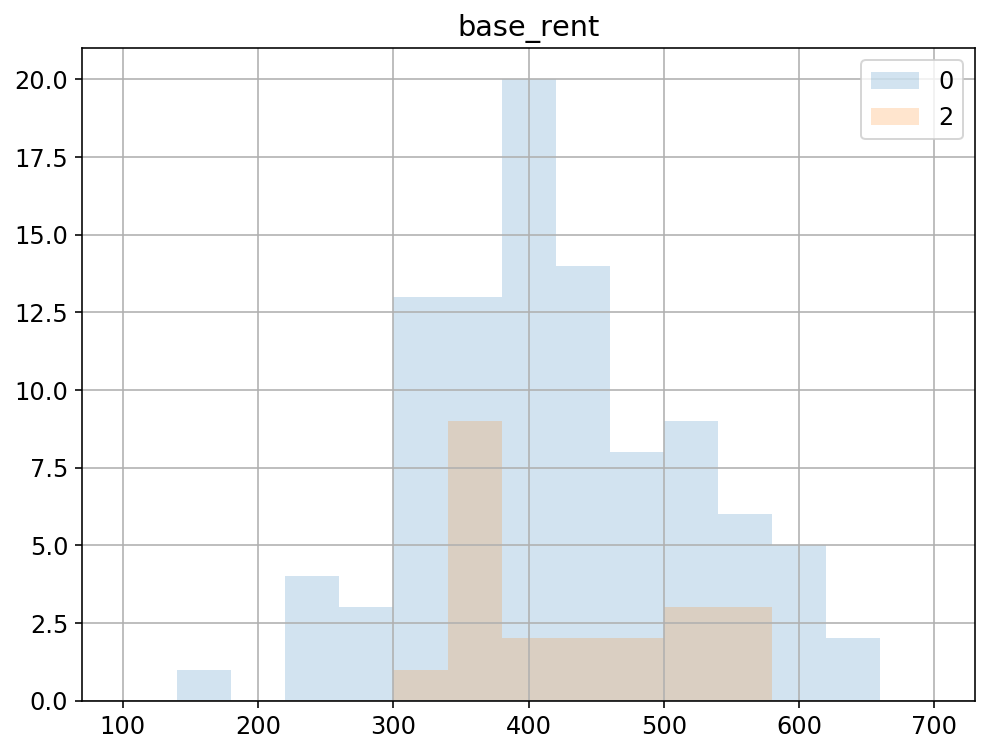

In [693]:
grps = df.groupby('num_males_current')
for key, grp in df.groupby('num_males_current'):
    grp.hist('base_rent', sharex=True, sharey=True, ax=plt.gca(),
             bins=15, range=[100, 700], histtype='stepfilled', alpha=0.2, 
             normed=False, label=str(key))
plt.legend();

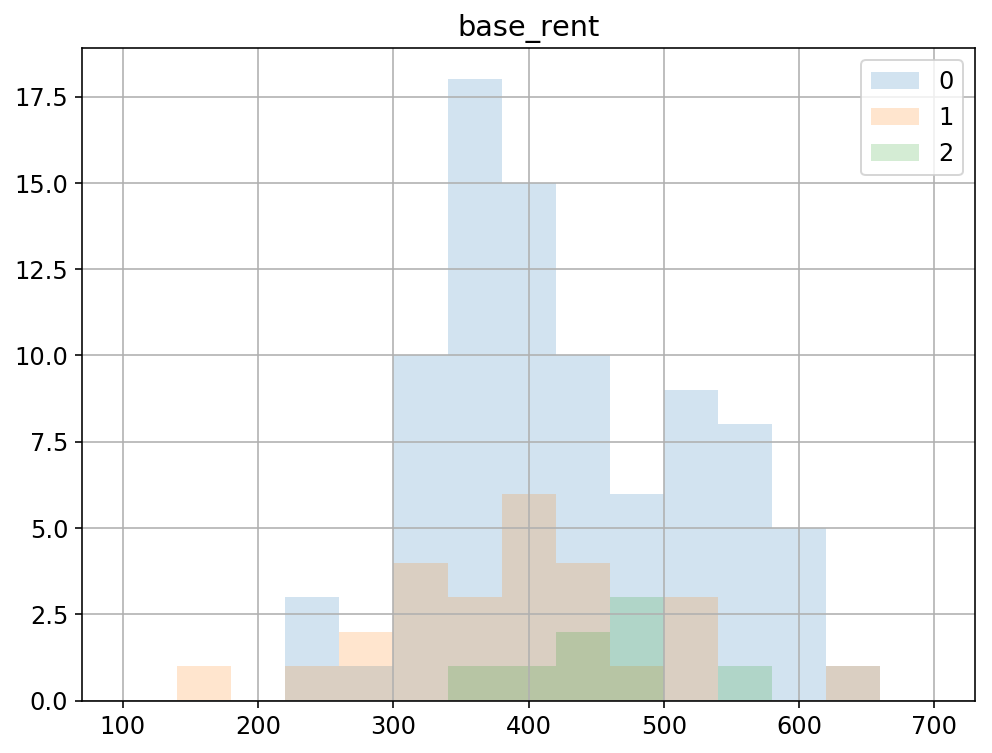

In [694]:
grps = df.groupby('num_females_current')
for key, grp in df.groupby('num_females_current'):
    grp.hist('base_rent', sharex=True, sharey=True, ax=plt.gca(),
             bins=15, range=[100, 700], histtype='stepfilled', alpha=0.2, 
             normed=False, label=str(key))
plt.legend();

In [707]:
def compare_distributions(groupby, column, **this_plot_opts):
    plot_opts = dict(histtype='stepfilled', alpha=0.2)
    plot_opts.update(this_plot_opts)
    grps = df.groupby(groupby)
    for key, grp in df.groupby(groupby):
        grp.hist(column, sharex=True, sharey=True, ax=plt.gca(),
                 label=str(key), **plot_opts)
    plt.legend();

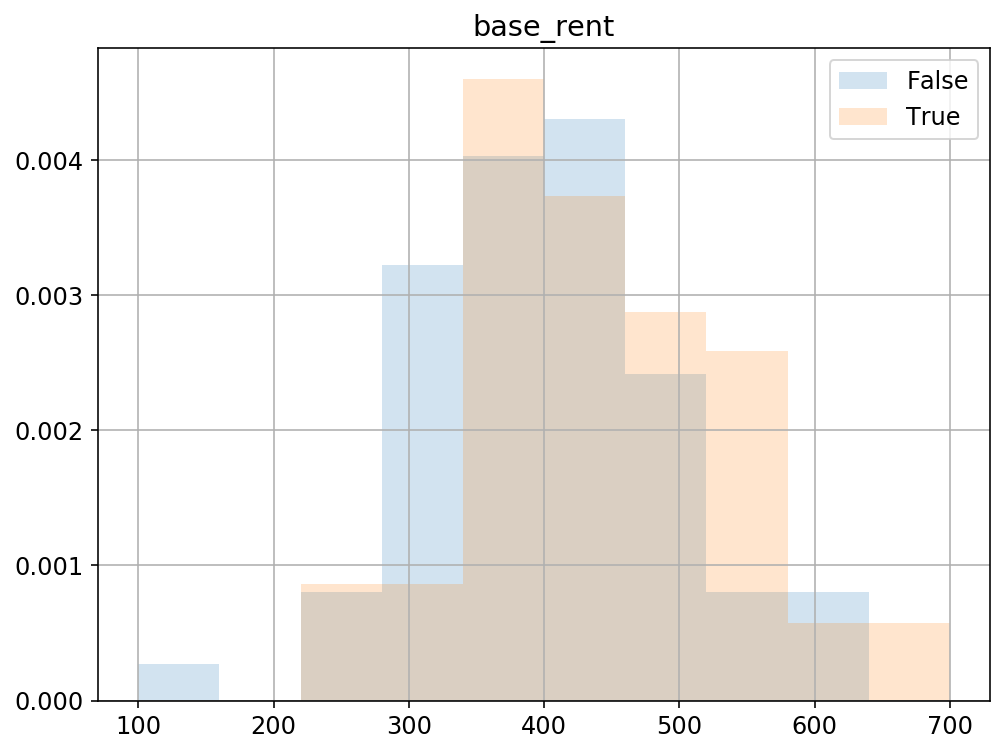

In [710]:
compare_distributions('students_ok', 'base_rent', bins=10, range=[100, 700], normed=True)

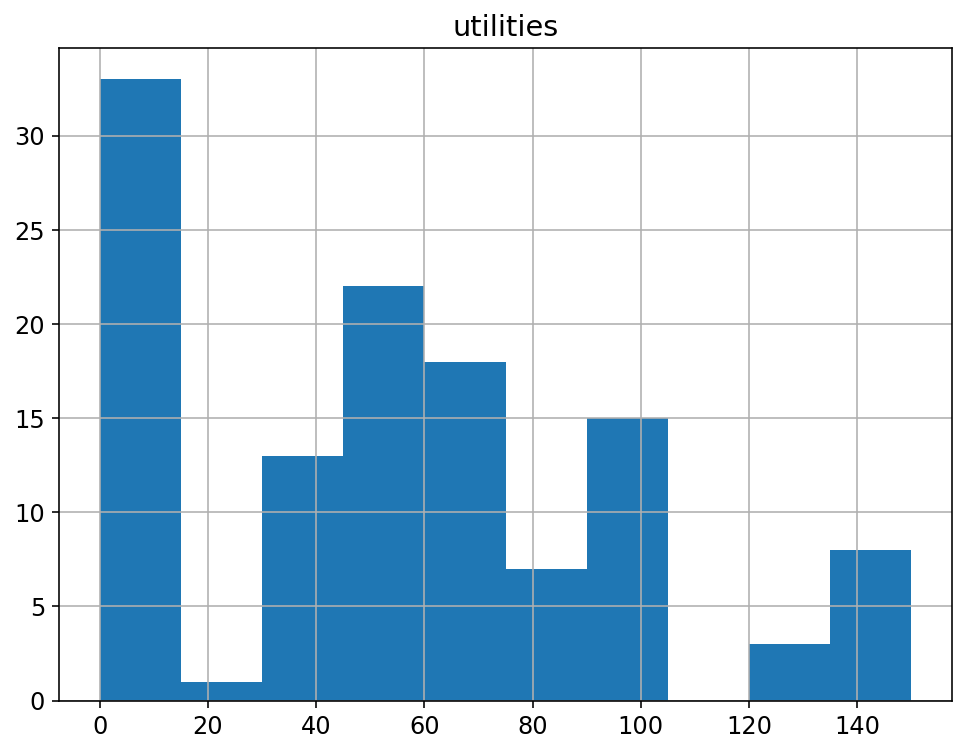

In [546]:
df.hist('utilities');

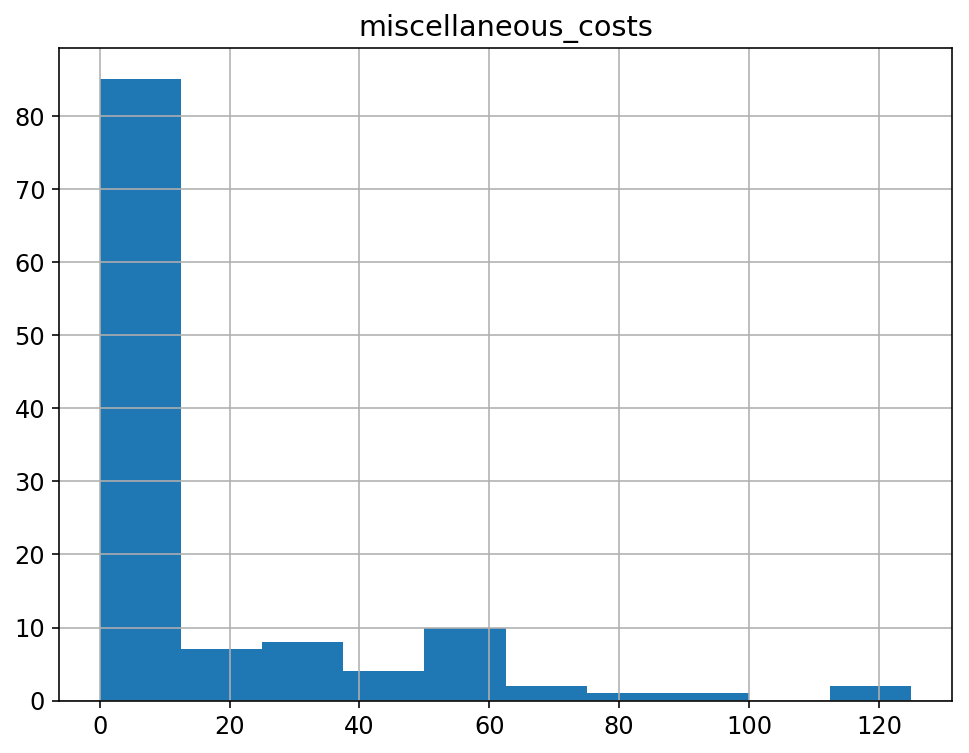

In [547]:
df.hist('miscellaneous_costs');

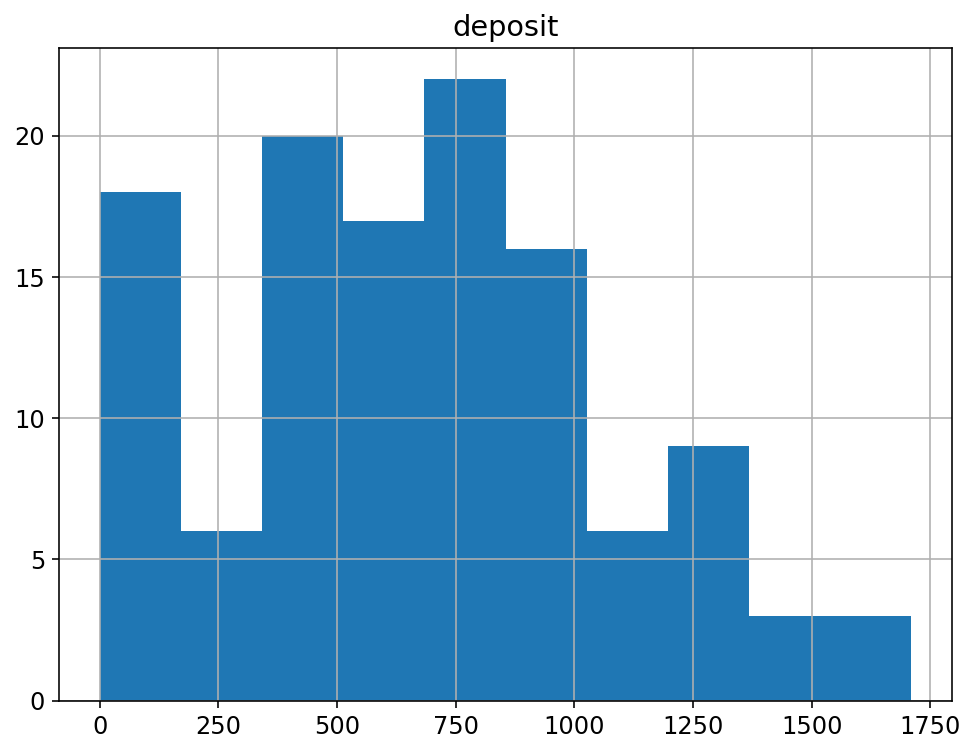

In [548]:
df.hist('deposit');

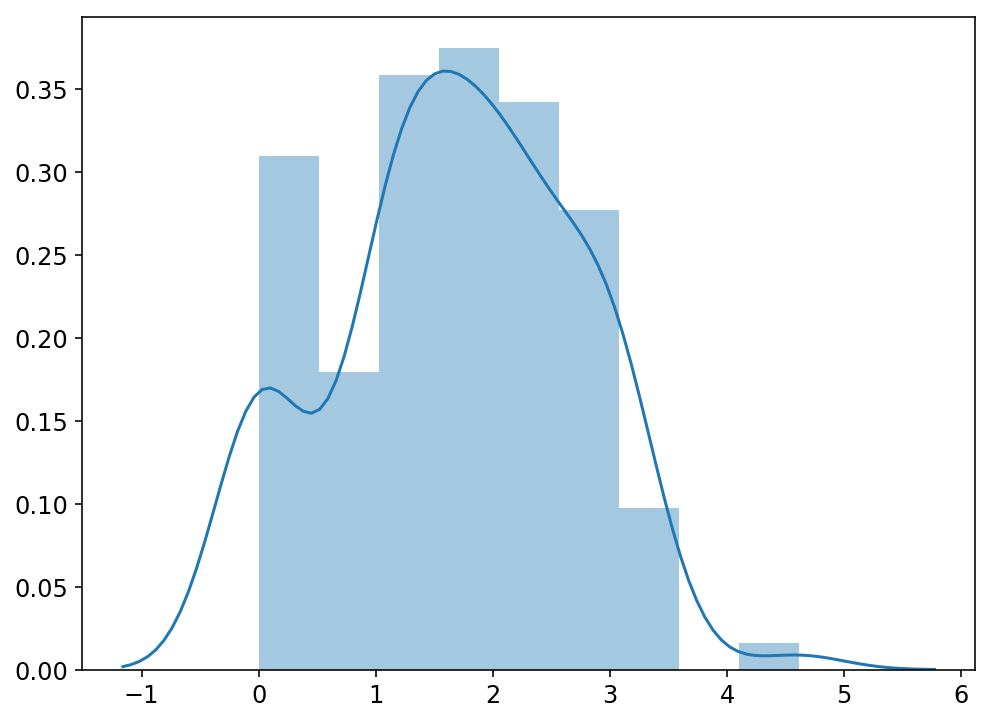

In [549]:
sns.distplot(df.deposit / df.base_rent);

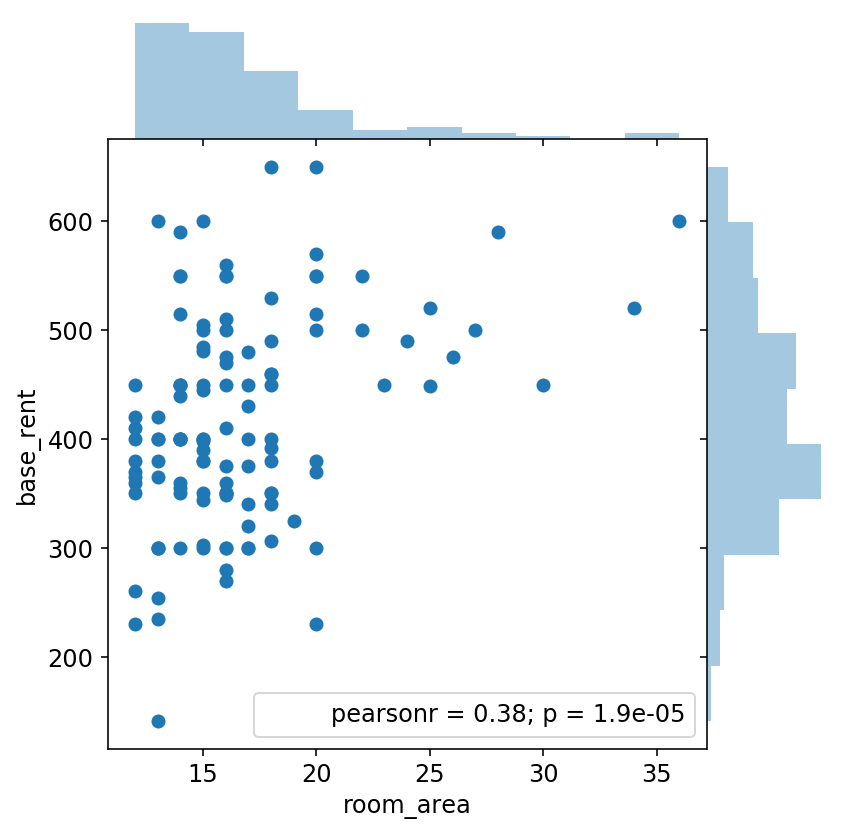

In [550]:
sns.jointplot(x='room_area', y='base_rent', 
              data=df, 
              space=0, marginal_kws={'bins': 10});

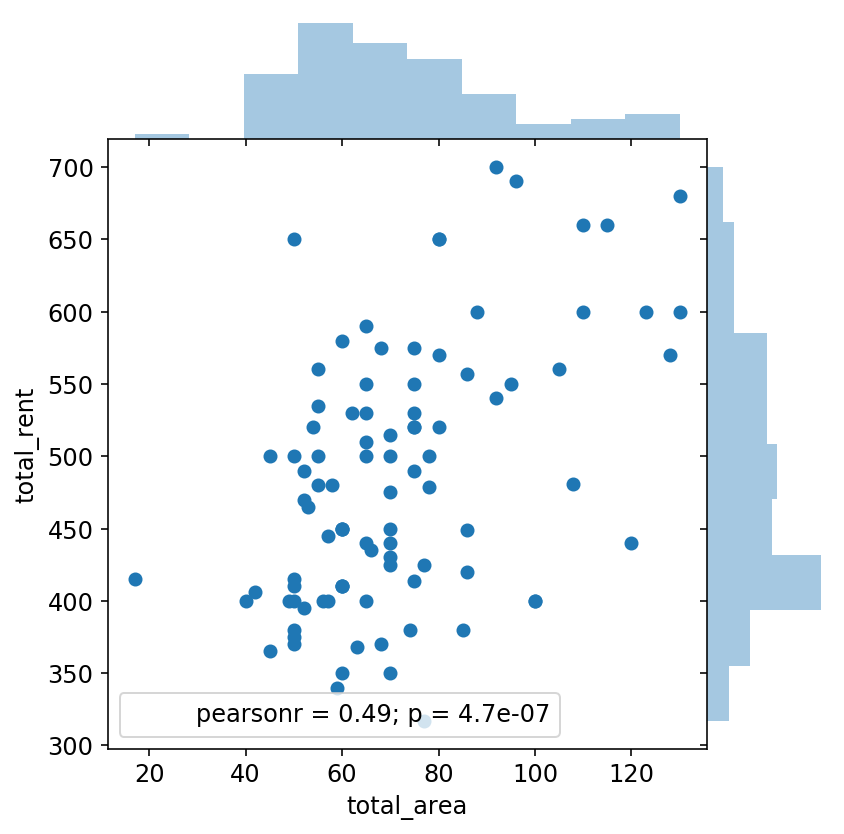

In [551]:
sns.jointplot(x='total_area', y='total_rent', 
              data=df.query('total_area>0'), 
              space=0, marginal_kws={'bins': 10});

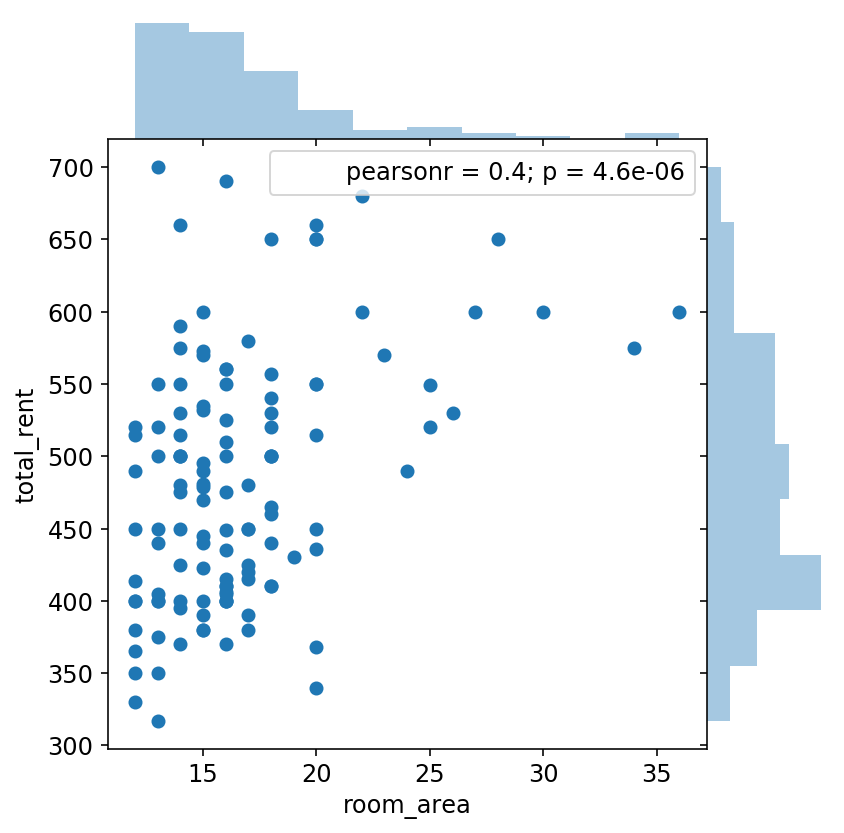

In [552]:
sns.jointplot(x='room_area', y='total_rent', 
              data=df, 
              space=0, marginal_kws={'bins': 10});

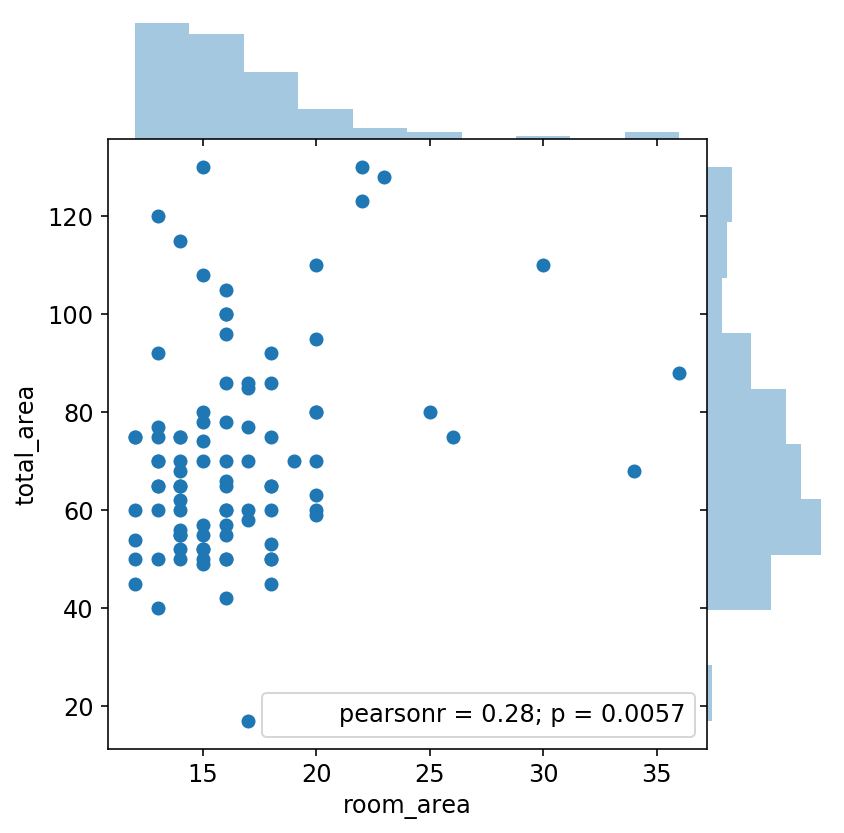

In [553]:
sns.jointplot(x='room_area', y='total_area', 
              data=df.query('total_area>0'), 
              space=0, marginal_kws={'bins': 10});

In [554]:
df.num_males_current.max()

2

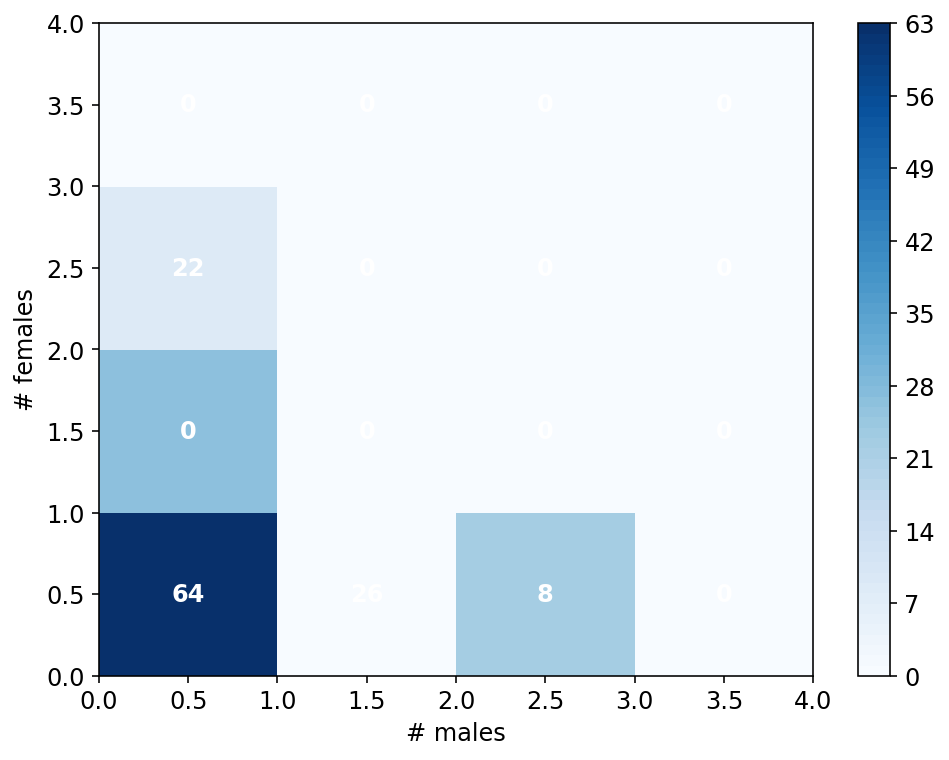

In [720]:
vals, xbins, ybins = np.histogram2d(df.num_males_current, df.num_females_current,
                                    bins=[range(5), range(5)])
hist, xbins, ybins, im = plt.hist2d(df.num_males_current, df.num_females_current,
                                    bins=[range(5), range(5)],
                                    norm=colors.BoundaryNorm(boundaries=range(int(vals.max())), ncolors=256), 
                                    cmap='Blues');
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        plt.text(xbins[j]+0.5,ybins[i]+0.5, int(hist[i,j]), 
                color="w", ha="center", va="center", fontweight="bold")

plt.xlabel('# males')
plt.ylabel('# females')
plt.colorbar();

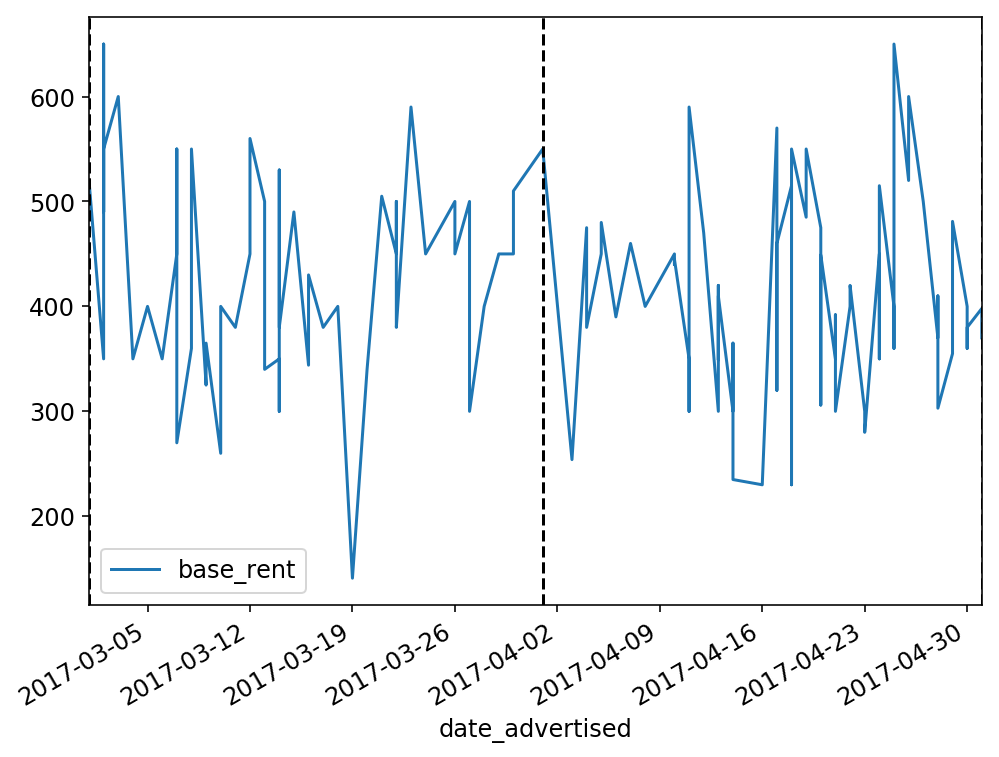

In [649]:
df.plot(x='date_advertised', y='base_rent');
plt.axvline('2017-03-01', c='black', linestyle='dashed');
plt.axvline('2017-04-01', c='black', linestyle='dashed');
plt.axvline('2017-05-01', c='black', linestyle='dashed');

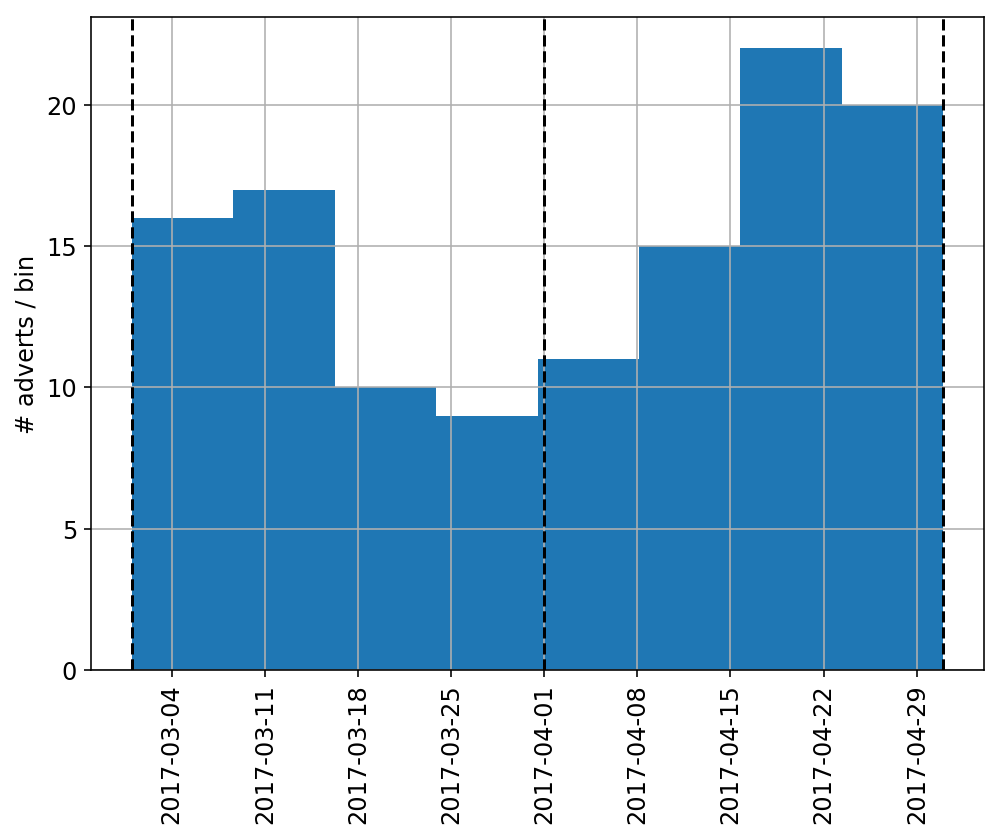

In [648]:
df.date_advertised.hist(bins=8, xrot=90, range=['2017-03-01', '2017-05-01']);
plt.ylabel('# adverts / bin')
plt.axvline('2017-03-01', c='black', linestyle='dashed');
plt.axvline('2017-04-01', c='black', linestyle='dashed');
plt.axvline('2017-05-01', c='black', linestyle='dashed');

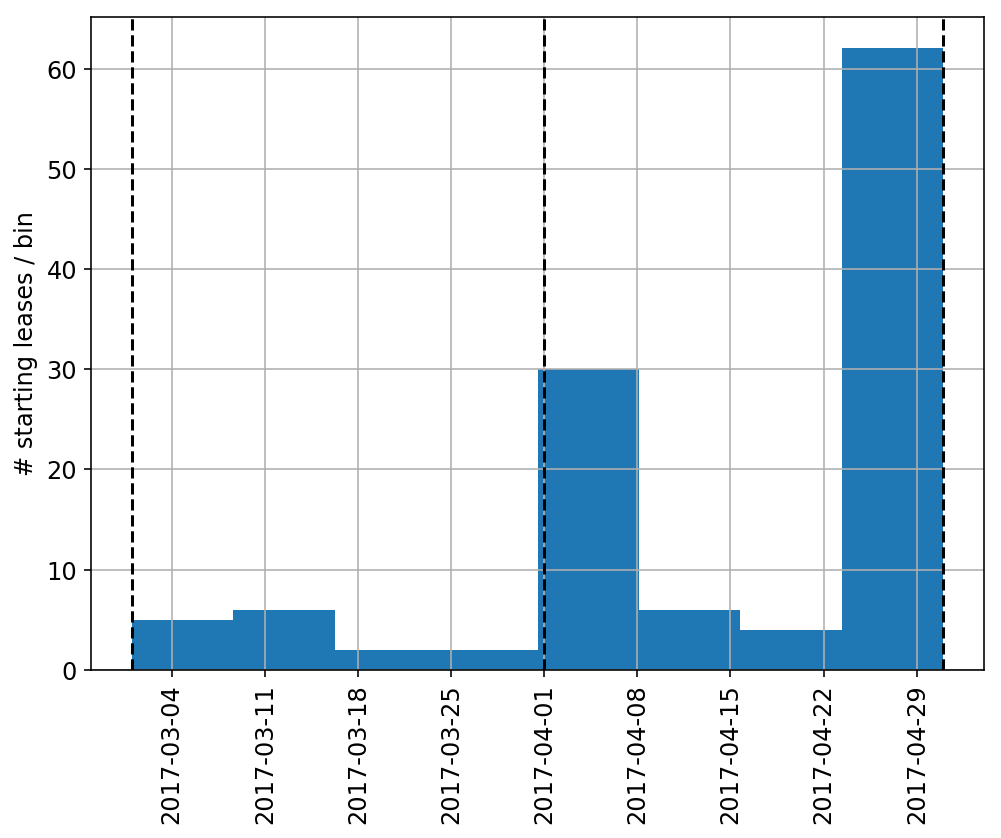

In [651]:
df.start_date.hist(bins=8, xrot=90, range=['2017-03-01', '2017-05-01']);
plt.ylabel('# starting leases / bin')
plt.axvline('2017-03-01', c='black', linestyle='dashed');
plt.axvline('2017-04-01', c='black', linestyle='dashed');
plt.axvline('2017-05-01', c='black', linestyle='dashed');

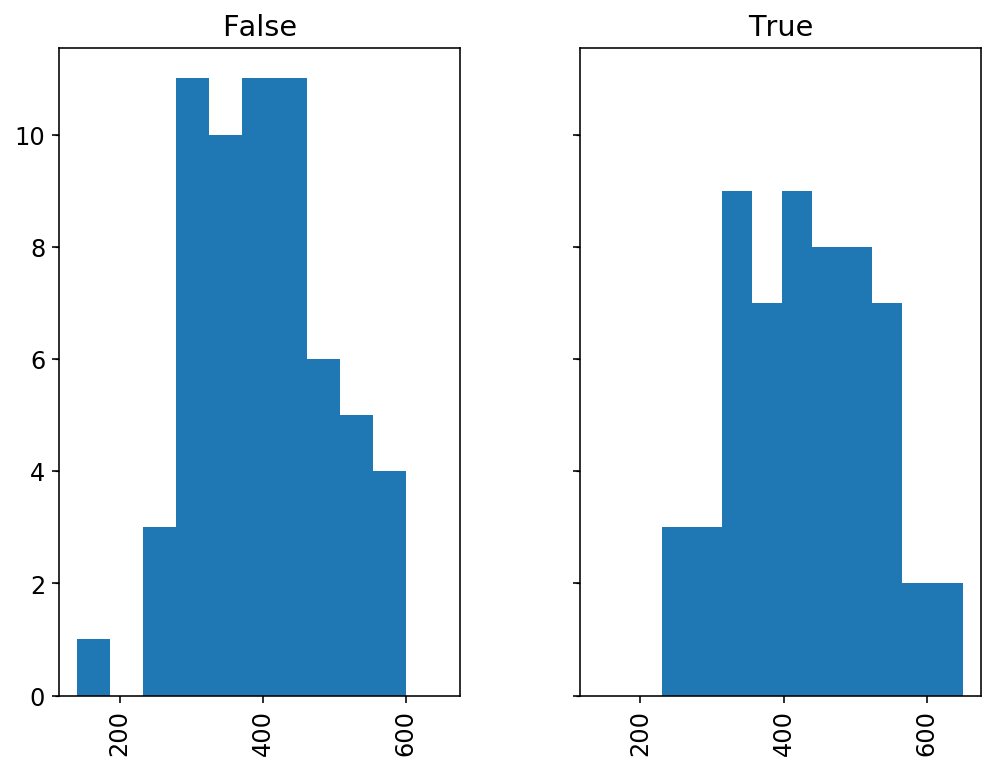

In [585]:
df.hist(column='base_rent', bins=10, by='students_ok', sharey=True, sharex=True);

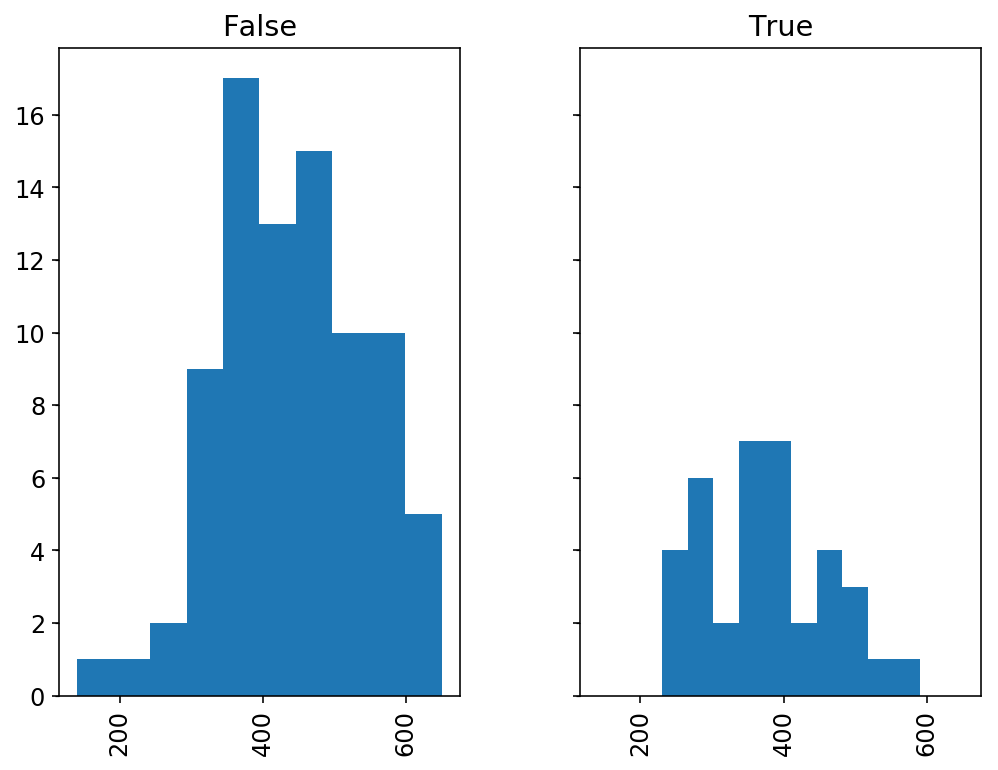

In [586]:
df.hist(column='base_rent', bins=10, by='workers_ok', sharey=True, sharex=True);

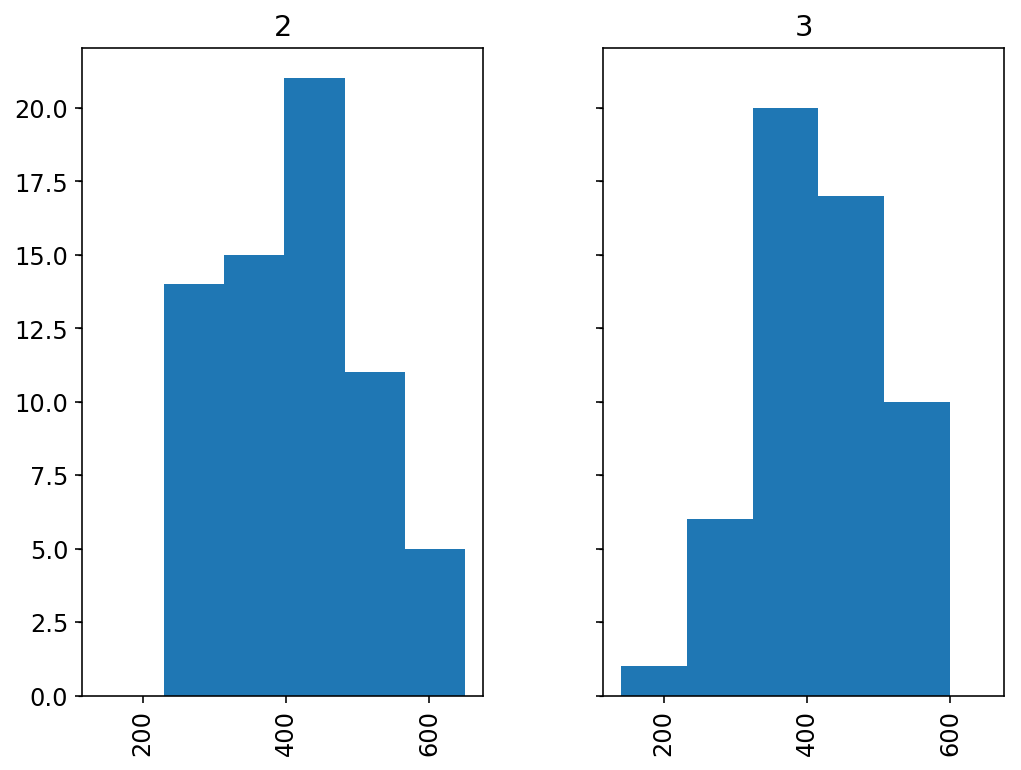

In [592]:
df.hist(column='base_rent', bins=5, by='total_occupancy', sharey=True, sharex=True);

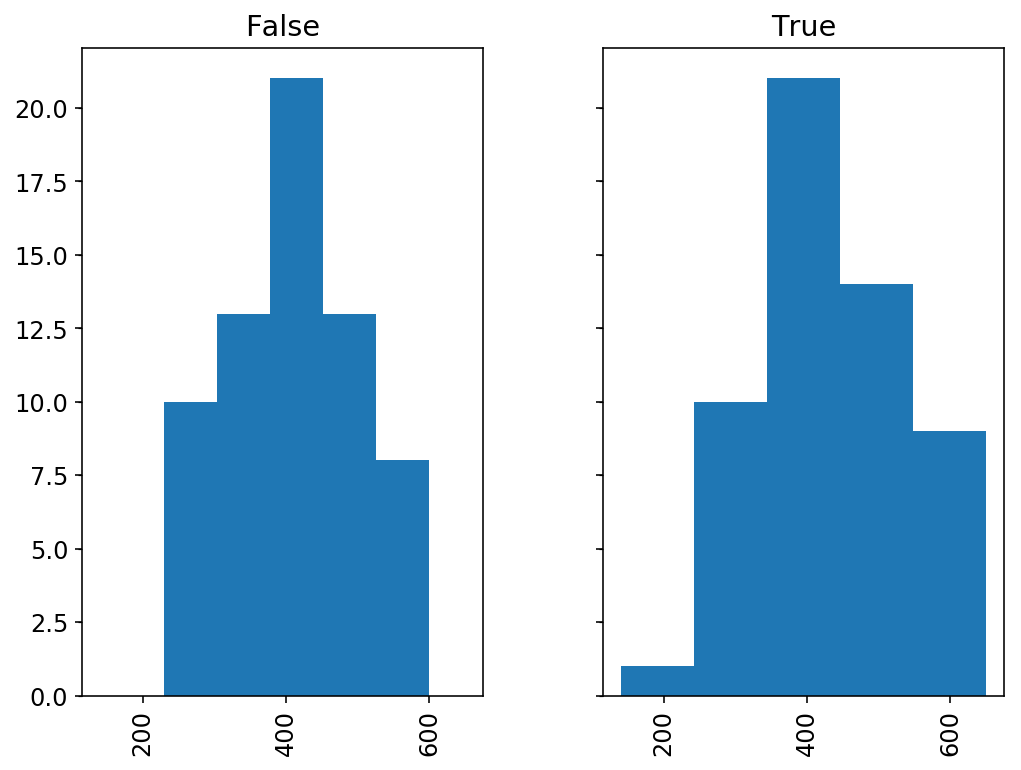

In [652]:
df.hist(column='base_rent', bins=5, by='balcony', sharey=True, sharex=True);

In [593]:
df.groupby('total_occupancy').base_rent.describe()

total_occupancy       
2                count     66.000000
                 mean     412.727273
                 std      100.512157
                 min      230.000000
                 25%      350.000000
                 50%      400.000000
                 75%      475.000000
                 max      650.000000
3                count     54.000000
                 mean     419.759259
                 std       95.276150
                 min      141.000000
                 25%      350.000000
                 50%      415.000000
                 75%      490.000000
                 max      600.000000
Name: base_rent, dtype: float64

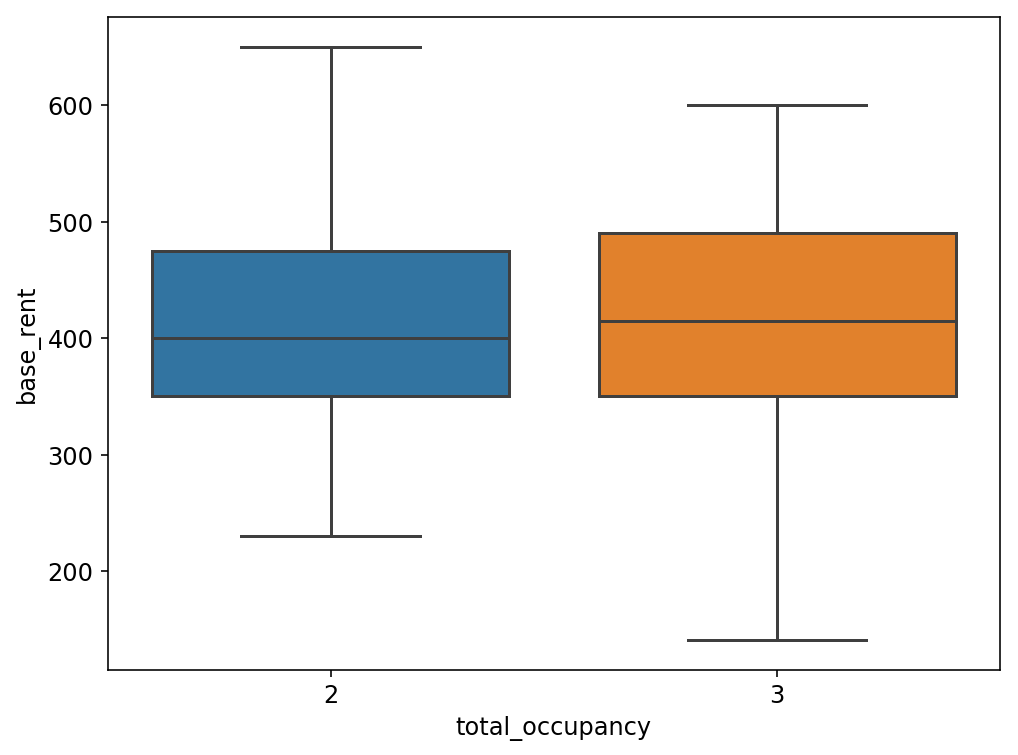

In [595]:
sns.boxplot(y='base_rent', x='total_occupancy', data=df);

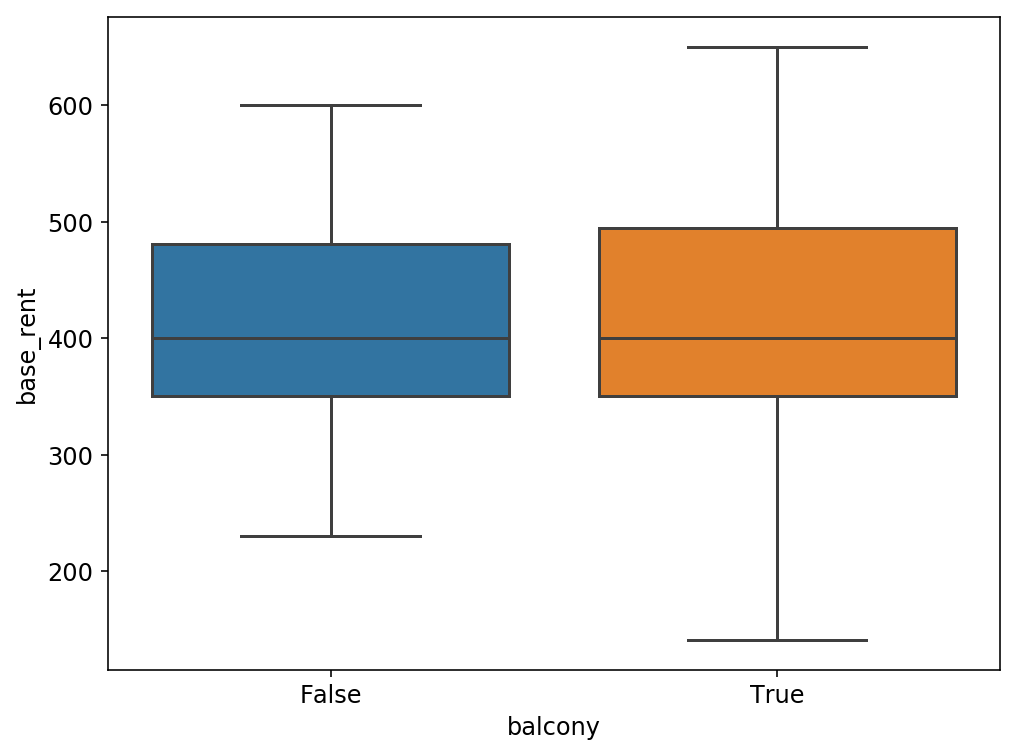

In [653]:
sns.boxplot(y='base_rent', x='balcony', data=df);

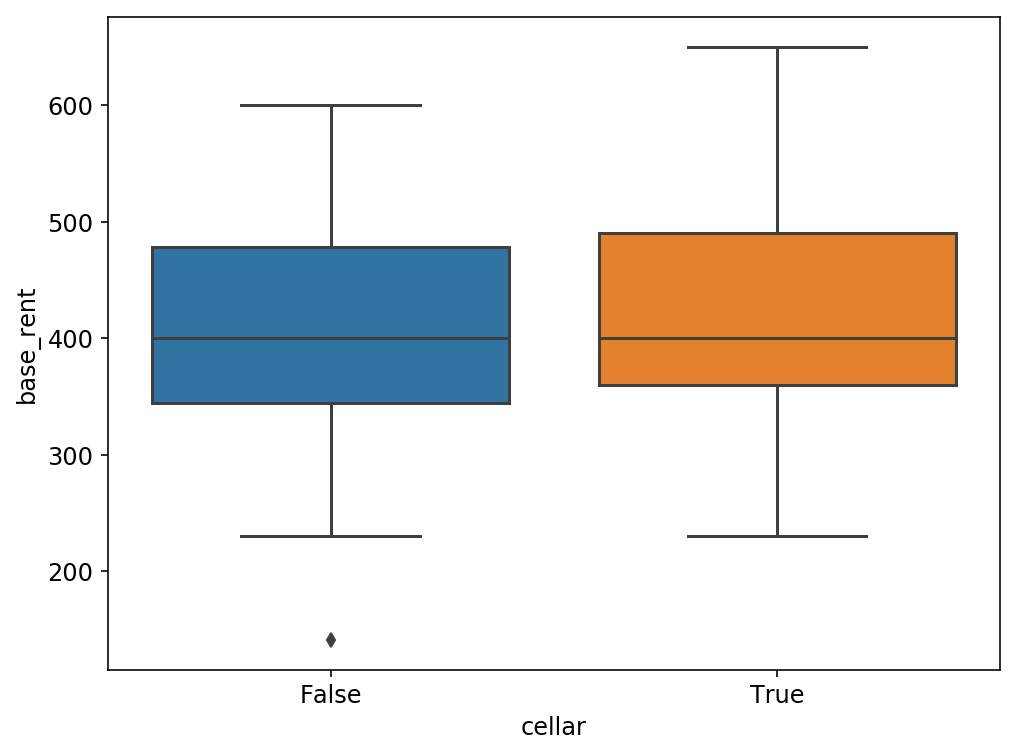

In [654]:
sns.boxplot(y='base_rent', x='cellar', data=df);

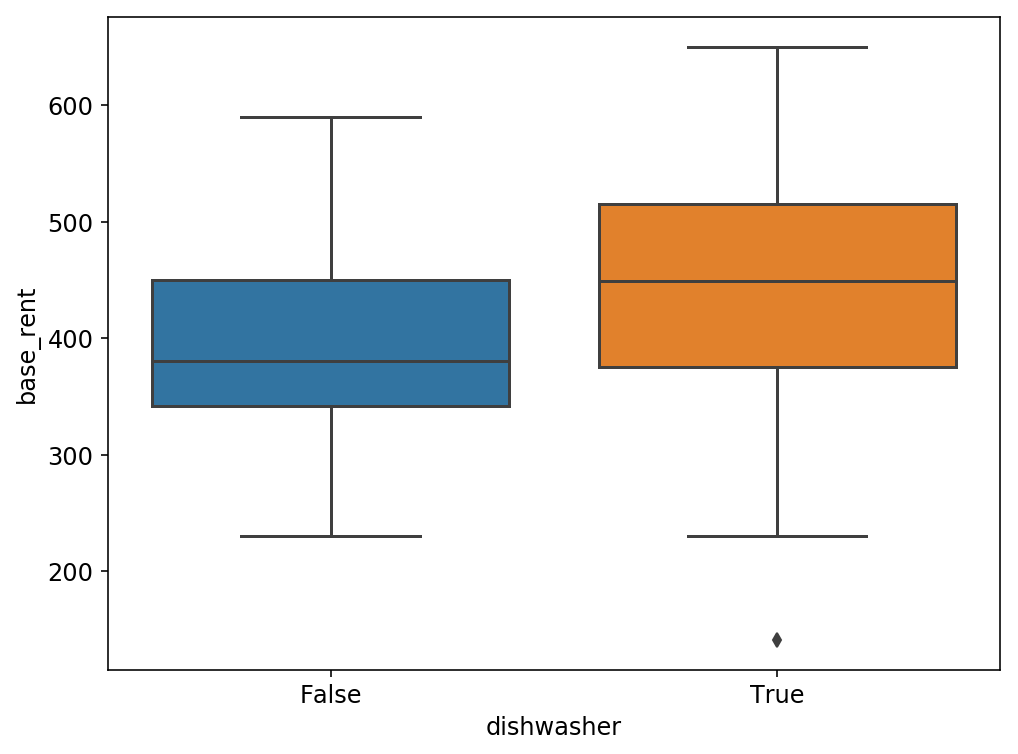

In [655]:
sns.boxplot(y='base_rent', x='dishwasher', data=df);

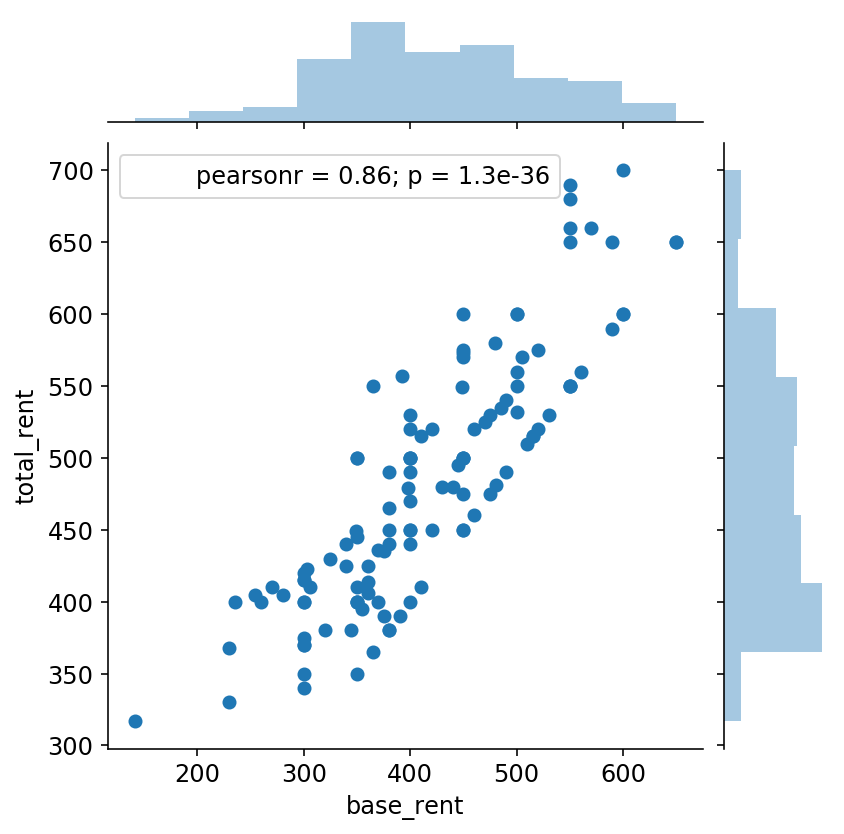

In [597]:
sns.jointplot(x='base_rent', y='total_rent', data=df);
# df.plot.scatter(x='base_rent', y='total_rent');

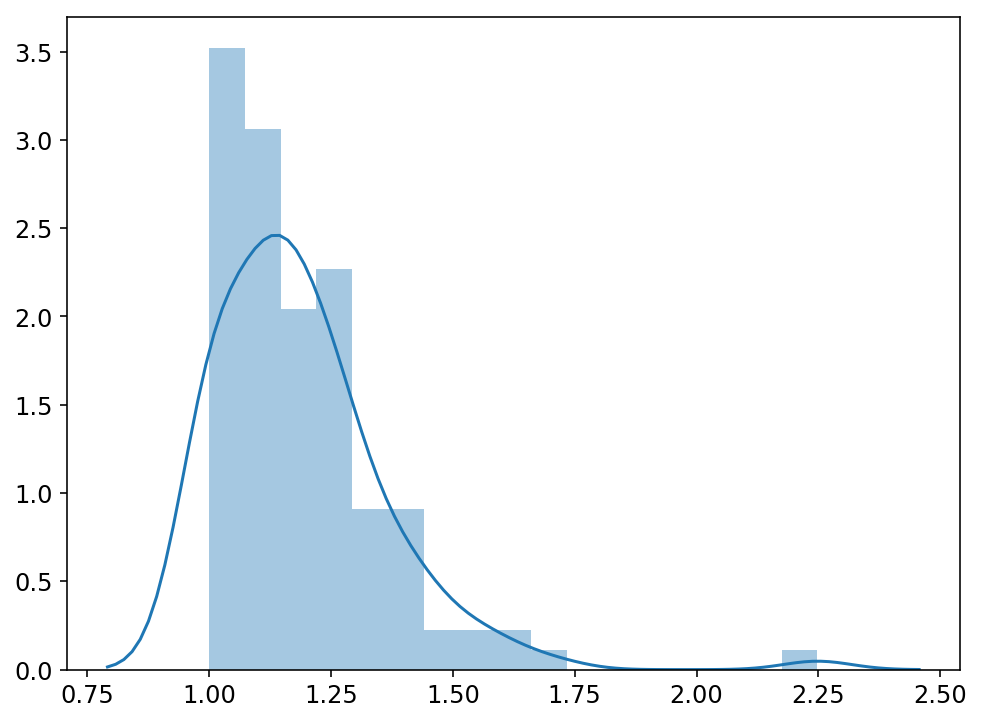

In [590]:
sns.distplot(df.total_rent/df.base_rent);

In [563]:
df.groupby('students_ok').describe(percentiles=[])

base_rent  current_max_age  current_min_age      deposit  \
students_ok                                                                    
False       count   62.000000        62.000000        62.000000    62.000000   
            mean   401.322581        20.290323        16.741935   649.338710   
            std     95.299489        16.042349        12.811285   453.053644   
            min    141.000000        -1.000000        -1.000000     0.000000   
            50%    399.000000        24.500000        21.500000   625.000000   
            max    600.000000        77.000000        60.000000  1710.000000   
True        count   58.000000        58.000000        58.000000    58.000000   
            mean   431.465517        22.965517        18.844828   701.086207   
            std     98.943935        18.372334        13.799061   372.109458   
            min    230.000000        -1.000000        -1.000000     0.000000   
            50%    405.000000        26.500000        23.500000   673.500000   
            max    650.000000        89.000000        40.000000  1600.000000   

                   desired_max_age  desired_min_age   distance  \
students_ok                                                      
False       count        62.000000        62.000000  62.000000   
            mean         22.548387        13.564516   6.106452   
            std          16.529831         9.930283   2.044575   
            min          -1.000000        -1.000000   1.600000   
            50%          30.000000        18.000000   5.950000   
            max          55.000000        25.000000   9.900000   
True        count        58.000000        58.000000  58.000000   
            mean         30.931034        16.603448   6.010345   
            std          23.533375        10.310852   2.112676   
            min          -1.000000        -1.000000   1.100000   
            50%          31.500000        20.000000   5.500000   
            max          99.000000        26.000000  10.000000   

                   existing_equipment_fees  house_number  miscellaneous_costs  \
students_ok                                                                     
False       count                62.000000     62.000000            62.000000   
            mean                 13.870968     29.241935            14.096774   
            std                  50.679153     53.171447            26.913772   
            min                   0.000000     -1.000000             0.000000   
            50%                   0.000000      8.000000             0.000000   
            max                 300.000000    317.000000           125.000000   
True        count                58.000000     58.000000            58.000000   
            mean                 11.568966     38.810345            13.172414   
            std                  49.406695     62.520300            23.280997   
            min                   0.000000     -1.000000             0.000000   
            50%                   0.000000      6.000000             0.000000   
            max                 300.000000    257.000000            90.000000   

                      ...      speaks_japanisch  speaks_niederländisch  \
students_ok           ...                                                
False       count     ...             62.000000              62.000000   
            mean      ...              0.000000               0.016129   
            std       ...              0.000000               0.127000   
            min       ...              0.000000               0.000000   
            50%       ...              0.000000               0.000000   
            max       ...              0.000000               1.000000   
True        count     ...             58.000000              58.000000   
            mean      ...              0.017241               0.017241   
            std       ...              0.131306               0.131306   
            min       ...

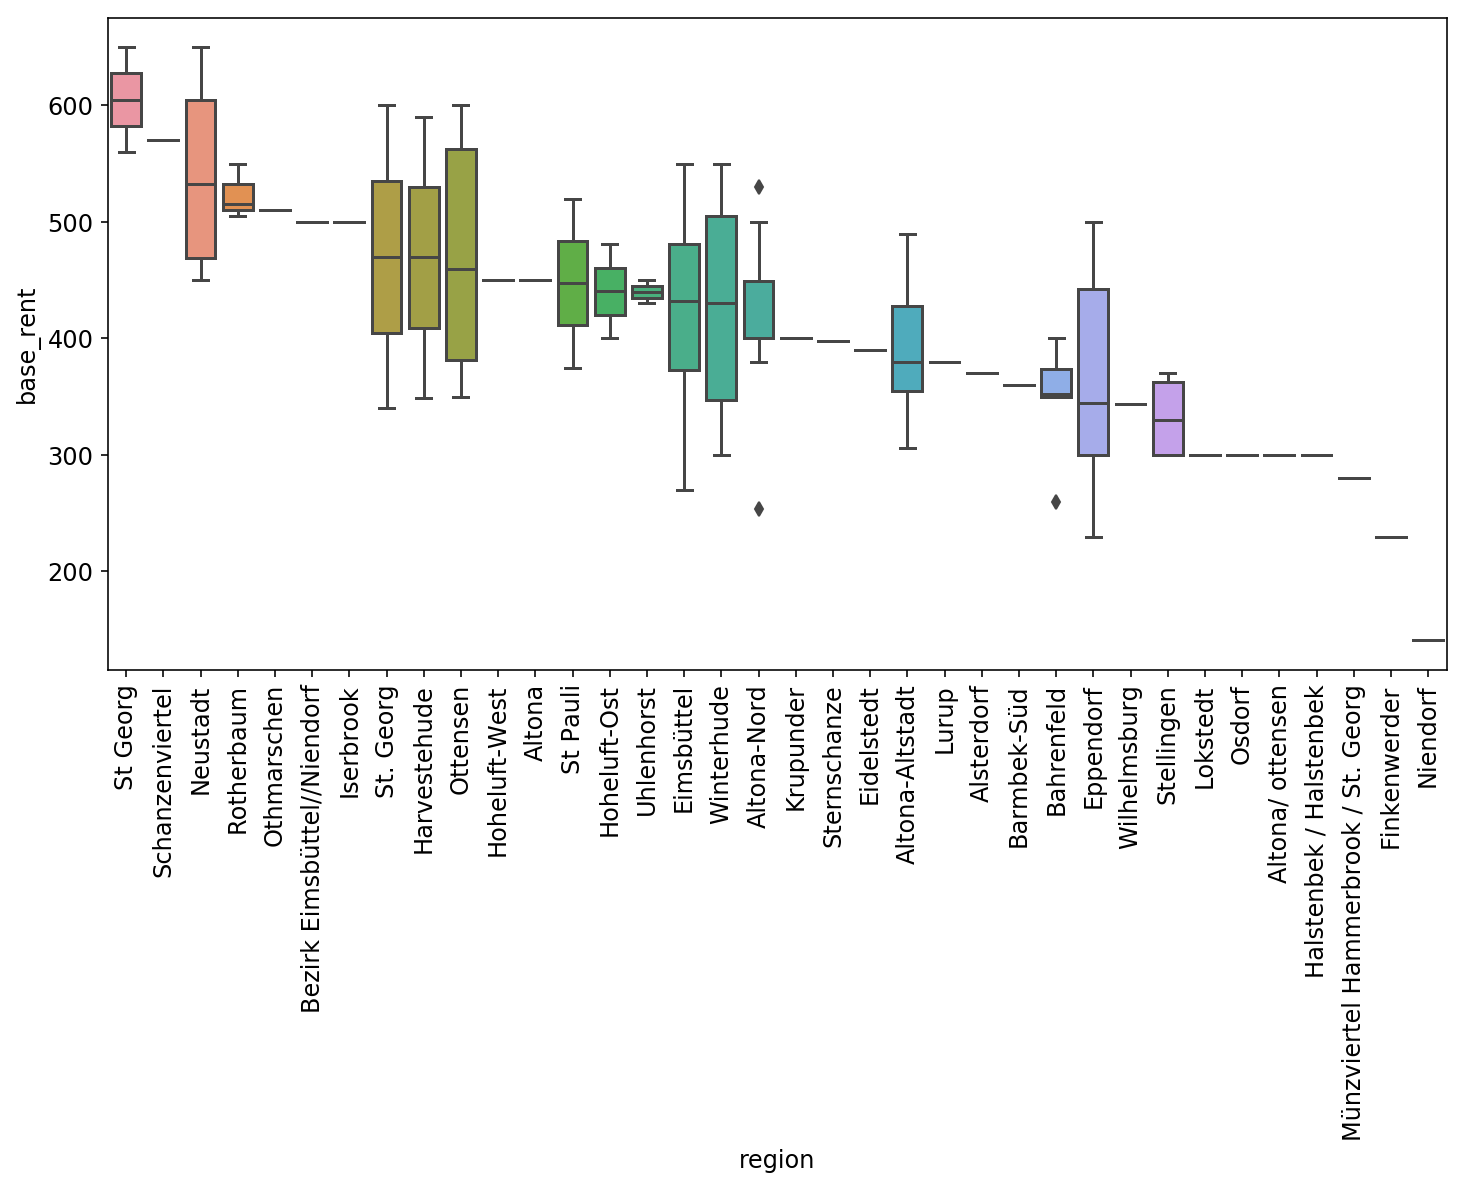

In [623]:
rr = df.groupby('region').base_rent.median().sort_values(ascending=False)
sns.boxplot(y="base_rent", data=df, x="region", order=rr.index);
plt.gcf().set_size_inches(12, 6);
plt.xticks(rotation=90);

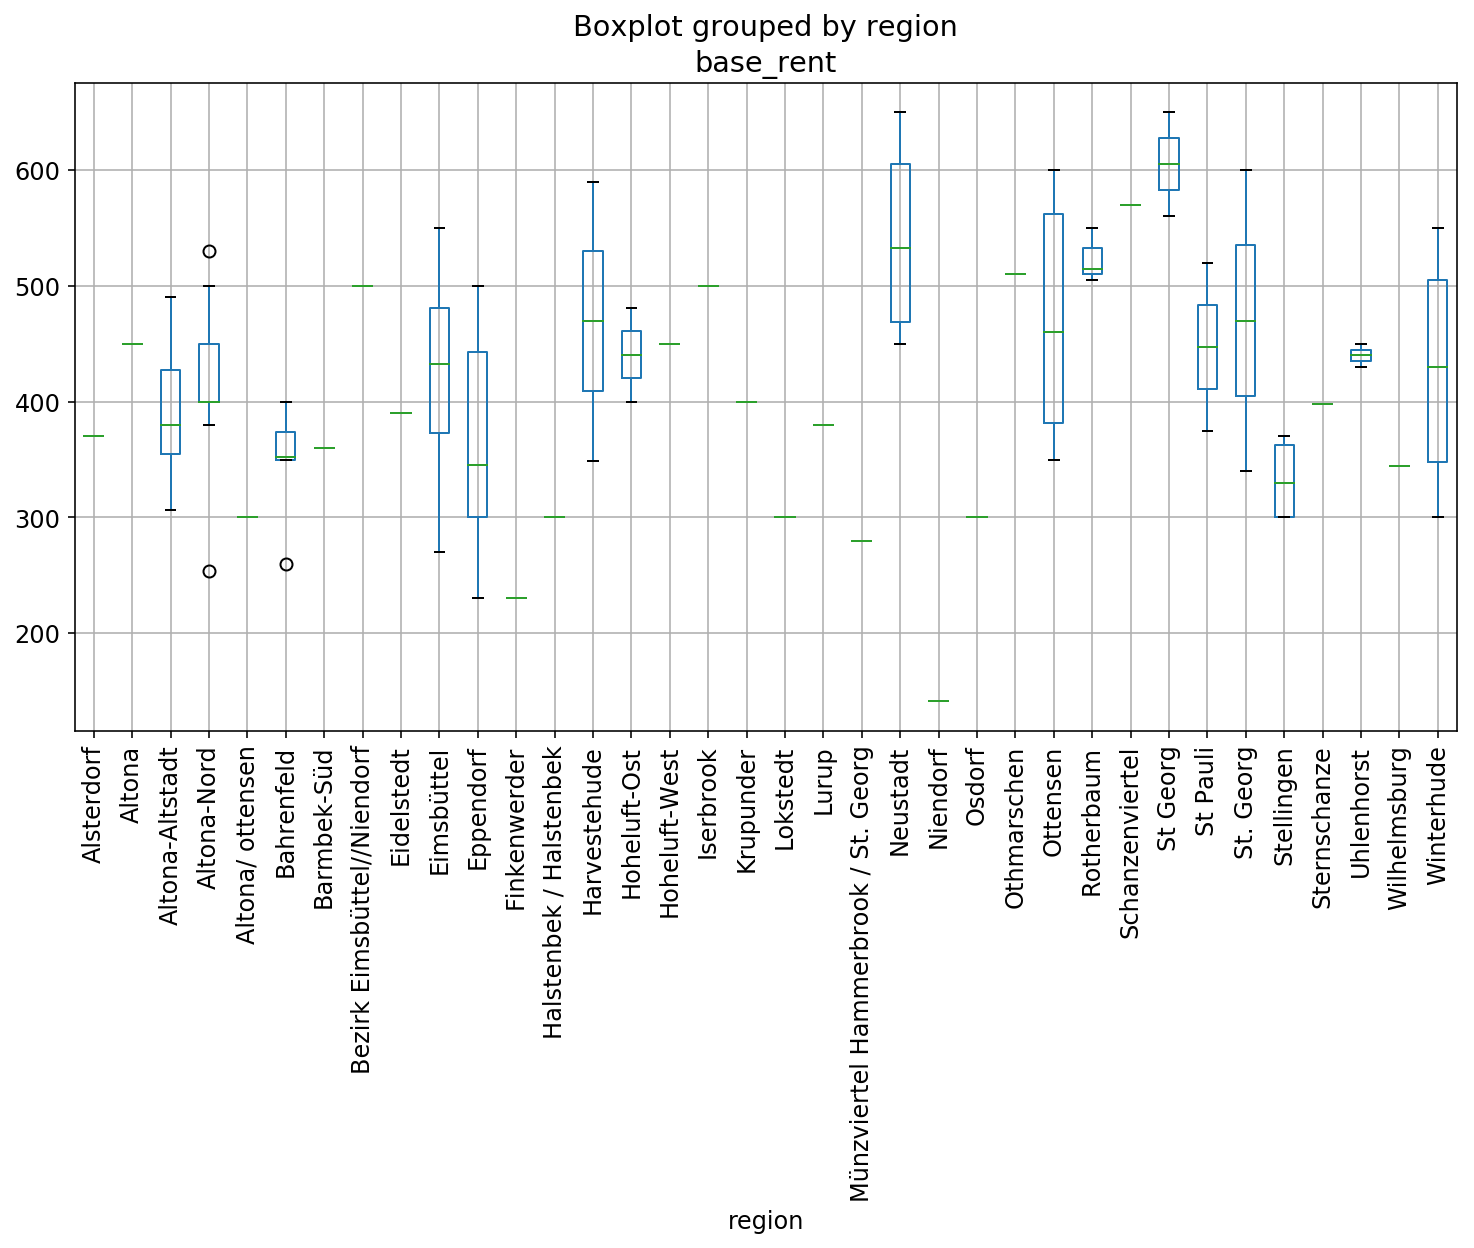

In [567]:
df.boxplot(column='base_rent', by='region', rot=90);
plt.gcf().set_size_inches(12, 6);

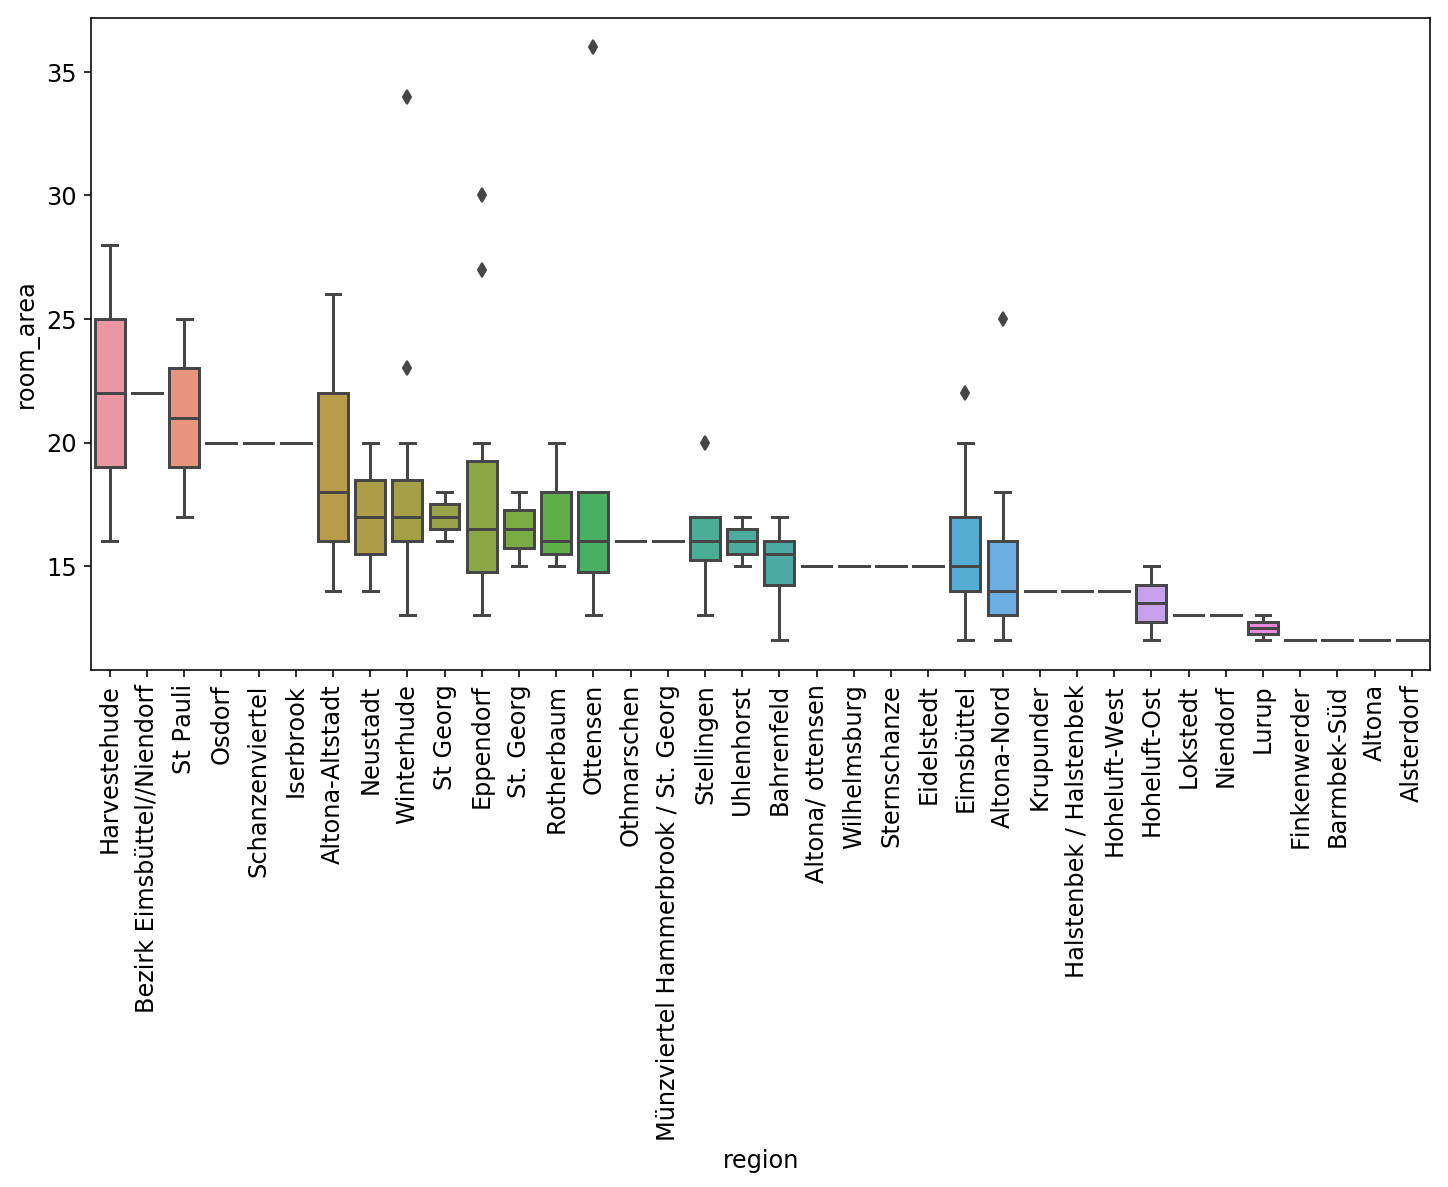

In [629]:
rr = df.groupby('region').room_area.median().sort_values(ascending=False)
sns.boxplot(y="room_area", data=df, x="region", order=rr.index);
plt.gcf().set_size_inches(12, 6);
plt.xticks(rotation=90);

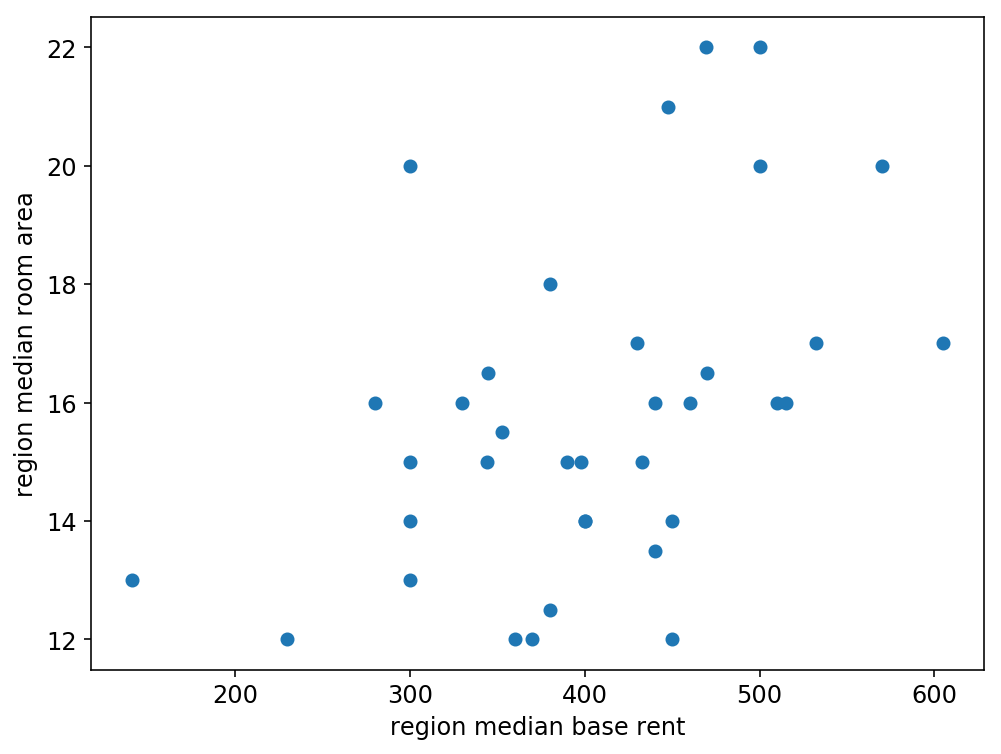

In [633]:
plt.scatter(df.groupby('region').base_rent.median().values, df.groupby('region').room_area.median().values);
plt.xlabel("region median base rent");
plt.ylabel("region median room area");

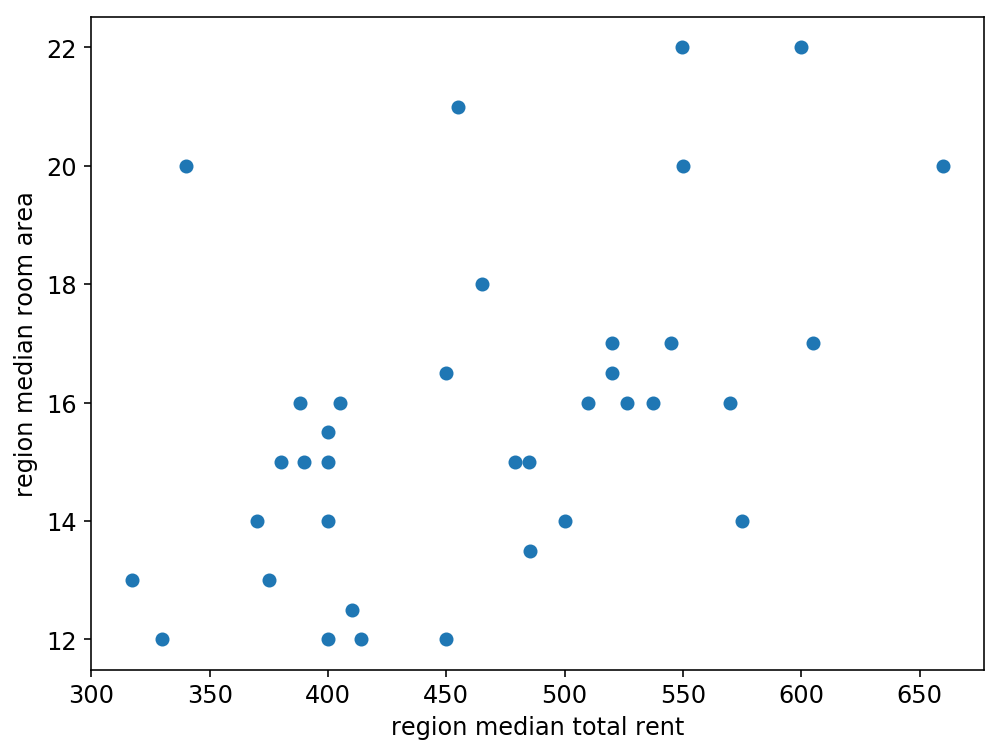

In [634]:
plt.scatter(df.groupby('region').total_rent.median().values, df.groupby('region').room_area.median().values);
plt.xlabel("region median total rent");
plt.ylabel("region median room area");

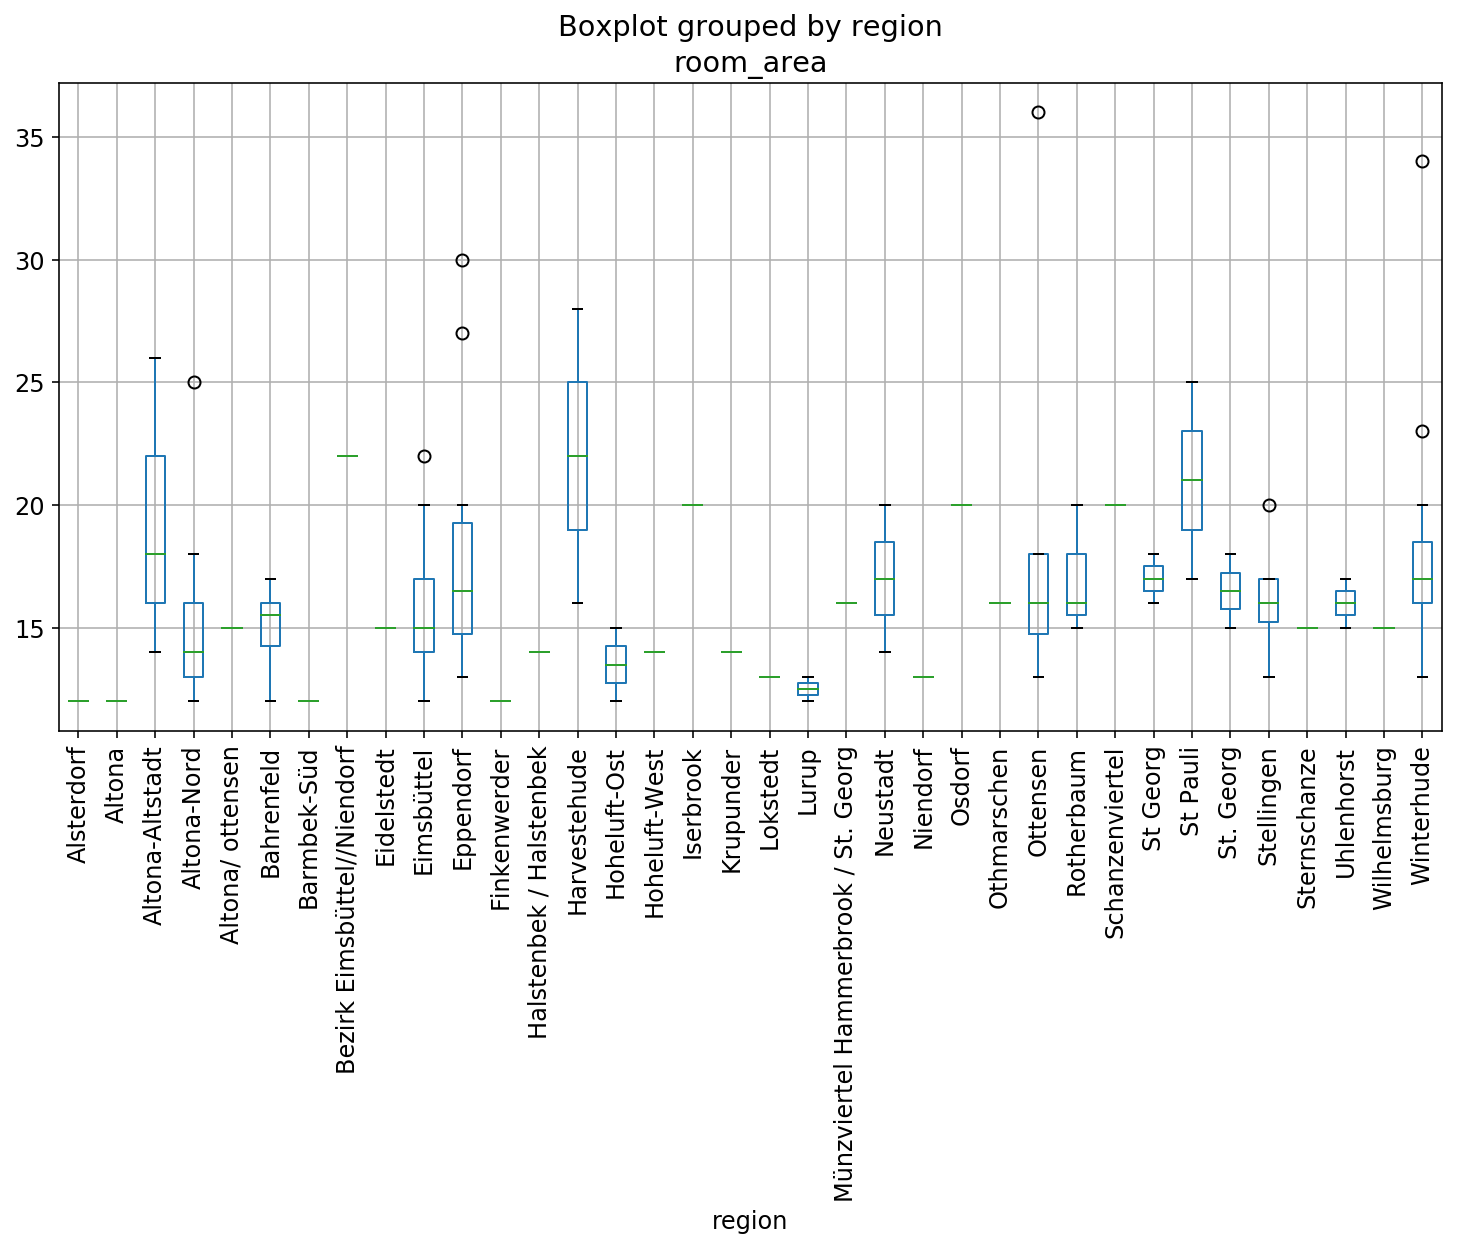

In [569]:
df.boxplot(column='room_area', by='region', rot=90);
plt.gcf().set_size_inches(12, 6);

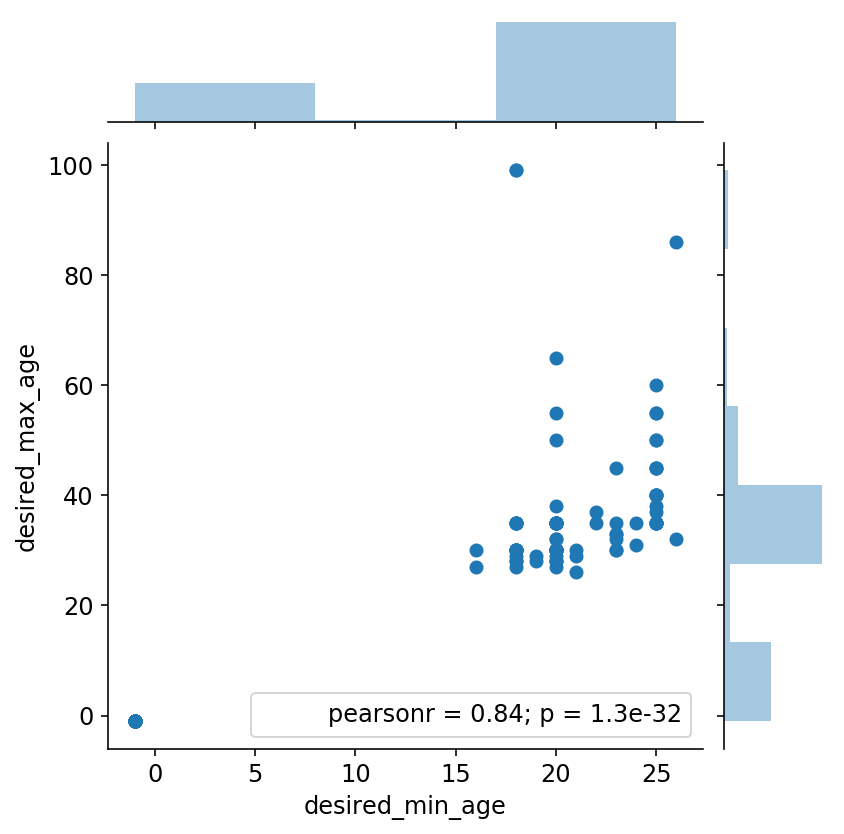

In [570]:
sns.jointplot(x='desired_min_age', y='desired_max_age', data=df);

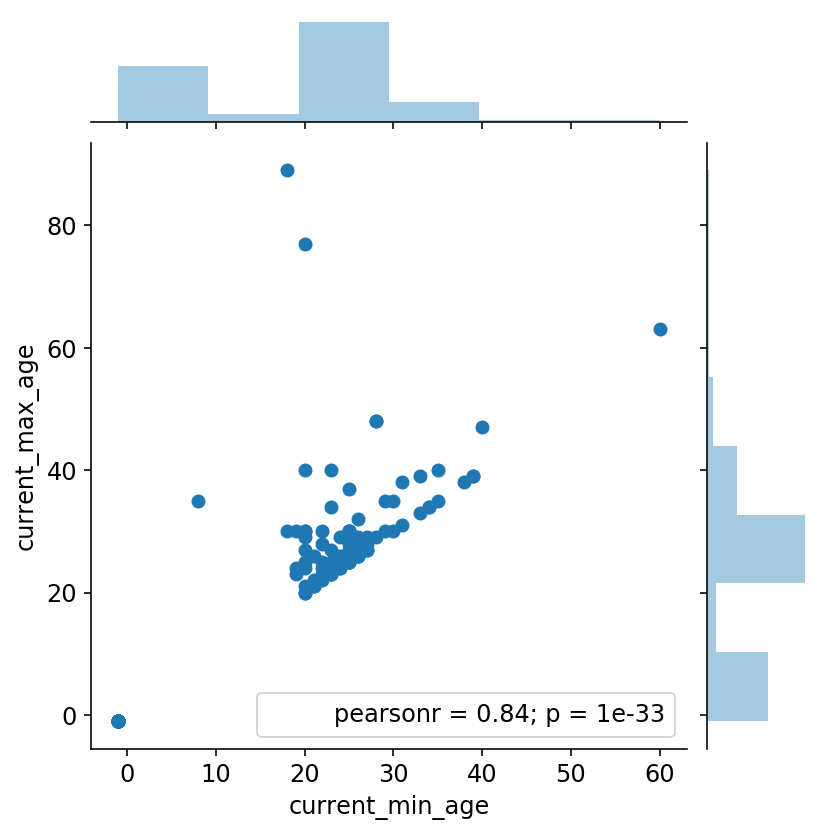

In [571]:
sns.jointplot(x='current_min_age', y='current_max_age', data=df);

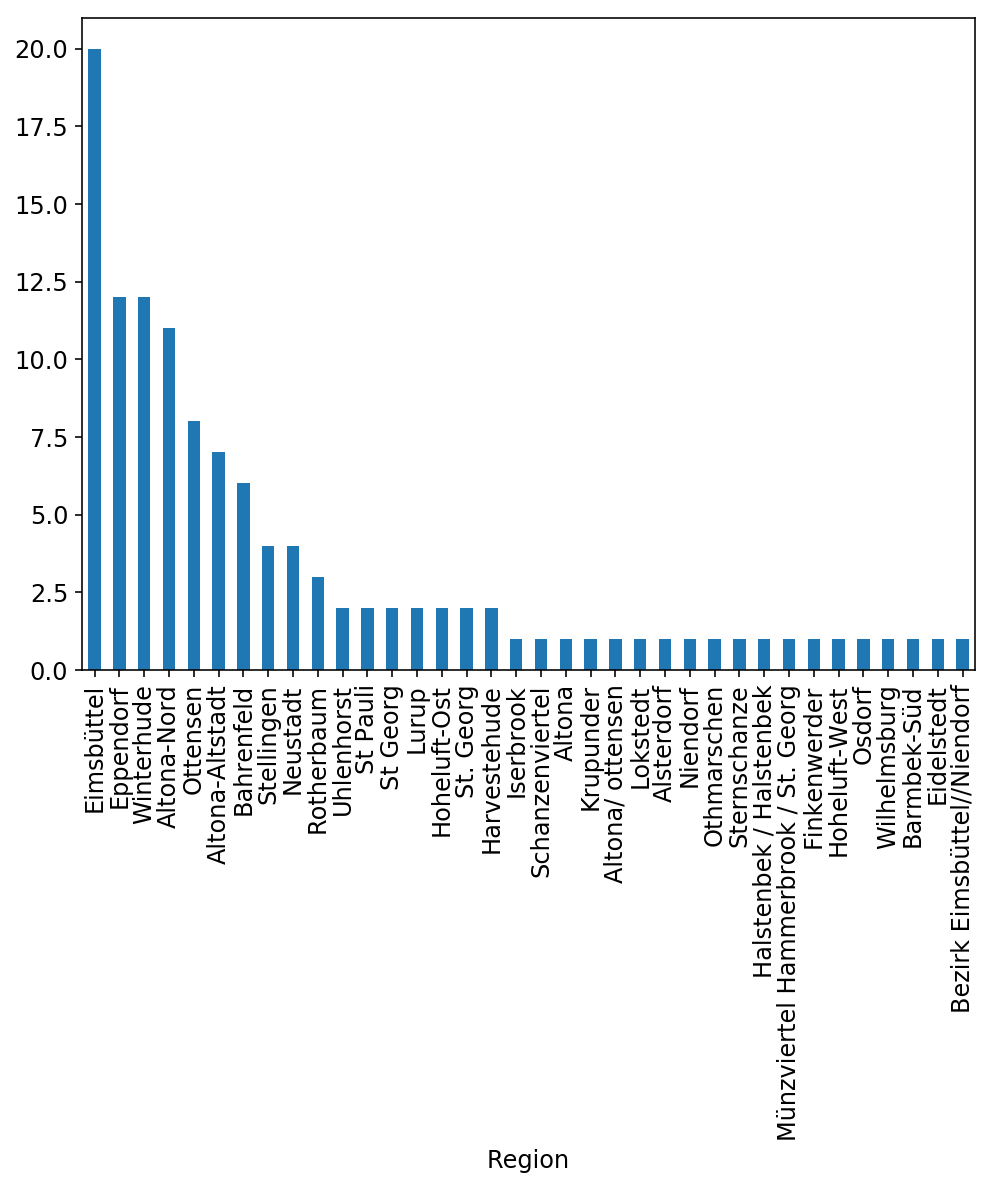

In [572]:
df.region.value_counts().plot(kind='bar');
plt.xlabel("Region");